# Distance Analysis: colon-xenium-stanford and colon-cycif-sorgerlab

> Analyze and visualize cell-to-nearest-endothelial-cell distance distributions for the `colon-xenium-stanford` and `colon-cycif-sorgerlab` datasets.

In [1]:
import numpy as np
import pandas as pd
import os
import json
import requests
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
import plotly.express as px

from _cde_compute_edges_from_nodes import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# suppress warnings
import warnings
warnings.filterwarnings("ignore")   

In [2]:
basepath = "/u/yashjain/hra-cell-distance-analysis/data"
dataset_dir = "colon-cycif-sorgerlab-xenium-stanford" # This variable is used only for figures. 
dataset_dir_1 = "colon-xenium-stanford" # This variable is used for data loading dataset 1.
dataset_dir_2 = "colon-cycif-sorgerlab" # This variable is used for data loading dataset 2.
data_filedir_1 = os.path.join("data-processed-nodes-with-harmonized-cell-types", dataset_dir_1)
output_edge_dir_1 = os.path.join("data-processed-edges", dataset_dir_1)
data_filedir_2 = os.path.join("data-processed-nodes-with-harmonized-cell-types", dataset_dir_2)
output_edge_dir_2 = os.path.join("data-processed-edges", dataset_dir_2)
figures_output_dir = "generated-figures"

In [3]:
# Function to load your data
def load_data(path, edges=False):
    if edges:
        column_names = ['cell_id', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2']
        data = pd.read_csv(path, header=None, names=column_names)
    else:
        data = pd.read_csv(path)
    return data

In [4]:
# Function to read all files ending with "-nodes.csv" in the `data_filedir` directory into a single DataFrame. 
# Another additional column `Dataset` is added to identify the dataset name which comes from the filename before the `-nodes.csv` suffix.

# Additionally, function reads all files ending with "-edges.csv" in the `output_edge_dir` directory into a single DataFrame. 
# Three additional columns are added "Dataset", "Anchor Cell Type", and "Anchor Cell Type Level" to identify the dataset name, anchor cell type, and anchor cell type level respectively which come from the filename before the `.csv` suffix.
# The three additional columns are created by splitting the filename on the `-` character, and extracting the relevant parts.
# On splitting, the first part is the dataset name, second part is the anchor cell type level, and third part is the anchor cell type, and last part is the `edges` suffix.
# When reading files, check if the file has the correct format (i.e., ends with `-edges.csv`).

# Additionally, the function merges the edges DataFrame with the nodes DataFrame to get the cell type information for the anchor cells.
# This is done by reading the corresponding nodes file from the `data_filedir` directory for each edges file, and merging it with the edges DataFrame on the `cell_id` column.
# The merged DataFrame contains the edges with additional columns for the cell type information.

# The function returns three DataFrames:
# 1. `merged_nodes`: DataFrame containing all nodes with an additional column `Dataset`.
# 2. `merged_edges`: DataFrame containing all edges with additional columns `Dataset`, `Anchor Cell Type`, and `Anchor Cell Type Level`.
# 3. `merged_nodes_for_all_edges`: DataFrame containing all edges with additional columns `Dataset`, `Anchor Cell Type`, `Anchor Cell Type Level`, and the cell type information for cells.
def read_all_edge_datasets(basepath, data_filedir, output_edge_dir):
    all_nodes_files = []
    all_edges_files = []
    all_nodes_edges_files = []
    for file in os.listdir(os.path.join(basepath, output_edge_dir)):
        if file.endswith("-edges.csv"):
            file_path = os.path.join(basepath, output_edge_dir, file)
            dataset_name, anchor_cell_type_level, anchor_cell_type = file.replace("-edges.csv", "").split('-')
            edges_df = load_data(file_path, edges=False)
            edges_df['Dataset'] = dataset_name
            edges_df['Anchor Cell Type'] = anchor_cell_type
            edges_df['Anchor Cell Type Level'] = anchor_cell_type_level
            edges_df.rename(columns={"distance": "Distance"}, inplace=True) # Rename column "distance" to "Distance".
            all_edges_files.append(edges_df)

            # Read the corresponding nodes file from data_filedir to get the cell type information
            nodes_file_path = os.path.join(basepath, data_filedir, f"{dataset_name}-nodes.csv")
            nodes_df = load_data(nodes_file_path)
            nodes_df['Dataset'] = dataset_name
            all_nodes_files.append(nodes_df)

            # Add a new 'cell_id' column to nodes_df
            nodes_df['cell_id'] = range(len(nodes_df))
            # Set 'cell_id' column as index for nodes_df
            nodes_df.set_index('cell_id', inplace=True)
            # Merge edges_df with nodes_df to get the cell type information for the anchor cells
            edges_nodes_df = pd.merge(edges_df, nodes_df[['Level Three Cell Type', 'Level Two Cell Type', 'Level One Cell Type']], how='left', left_on='cell_id', right_index=True)
            all_nodes_edges_files.append(edges_nodes_df)

    
    merged_edges = pd.concat(all_edges_files, ignore_index=True)
    merged_nodes = pd.concat(all_nodes_files, ignore_index=True)
    merged_nodes_for_all_edges = pd.concat(all_nodes_edges_files, ignore_index=True) 

    return merged_nodes, merged_edges, merged_nodes_for_all_edges

In [5]:
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")

## Get initial statistics and identify endothelial cell categories for dataset.

In [6]:
# Read all datasets from Dataset 1
df_all_nodes_1, df_all_edges_1, df_all_edges_with_cell_types_1 = read_all_edge_datasets(basepath, data_filedir_1, output_edge_dir_1)

# Create a column 'Tissue Type' in all three DataFrames with the value dataset_dir_1
df_all_nodes_1['Tissue Type'] = dataset_dir_1
df_all_edges_1['Tissue Type'] = dataset_dir_1
df_all_edges_with_cell_types_1['Tissue Type'] = dataset_dir_1

# Read all datasets from Dataset 2
df_all_nodes_2, df_all_edges_2, df_all_edges_with_cell_types_2 = read_all_edge_datasets(basepath, data_filedir_2, output_edge_dir_2)

# Create a column 'Tissue Type' in all three DataFrames with the value dataset_dir_2
df_all_nodes_2['Tissue Type'] = dataset_dir_2
df_all_edges_2['Tissue Type'] = dataset_dir_2
df_all_edges_with_cell_types_2['Tissue Type'] = dataset_dir_2

# Merge the two datasets
df_all_nodes = pd.concat([df_all_nodes_1, df_all_nodes_2], ignore_index=True)
df_all_edges = pd.concat([df_all_edges_1, df_all_edges_2], ignore_index=True)
df_all_edges_with_cell_types = pd.concat([df_all_edges_with_cell_types_1, df_all_edges_with_cell_types_2], ignore_index=True)

In [7]:
df_all_nodes.head(5)

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset,Tissue Type
0,1077.96,2556.82,Immature Goblet,goblet cell:immature,goblet cell:immature,CL:0000160,skos:narrowMatch,goblet cell,goblet cell,CL:0000160,skos:exactMatch,epithelial cell,epithelial cell,CL:0000066,skos:exactMatch,layer_3,colon-xenium-stanford
1,1079.01,2534.23,Tuft,tuft cell:intestinal,intestinal tuft cell,CL:0019032,skos:exactMatch,tuft cell,brush cell,CL:0002204,skos:exactMatch,epithelial cell,epithelial cell,CL:0000066,skos:exactMatch,layer_3,colon-xenium-stanford
2,1082.65,2554.09,TA1,transit amplifying cell,transit amplifying cell,CL:0009010,skos:exactMatch,enterocyte,enterocyte,CL:0000584,skos:exactMatch,epithelial cell,epithelial cell,CL:0000066,skos:exactMatch,layer_3,colon-xenium-stanford
3,1091.89,2547.38,Immature Goblet,goblet cell:immature,goblet cell:immature,CL:0000160,skos:narrowMatch,goblet cell,goblet cell,CL:0000160,skos:exactMatch,epithelial cell,epithelial cell,CL:0000066,skos:exactMatch,layer_3,colon-xenium-stanford
4,1253.46,2554.64,CD4+,t cell:cd4+ alpha-beta,"CD4-positive, alpha-beta T cell",CL:0000624,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,layer_3,colon-xenium-stanford


In [8]:
# Print the total number of unique cell types per dataset. Compute separately for each cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type).
print("Total number of unique cell types per cell type annnotation level:")
unique_cell_types = {
    'Original Cell Type': df_all_nodes['Original Cell Type'].nunique(),
    'Level Three Cell Type': df_all_nodes['Level Three Cell Type'].nunique(),
    'Level Two Cell Type': df_all_nodes['Level Two Cell Type'].nunique(),
    'Level One Cell Type': df_all_nodes['Level One Cell Type'].nunique()
}
for cell_type, count in unique_cell_types.items():
    print(f"{cell_type}: {count}")

Total number of unique cell types per cell type annnotation level:
Original Cell Type: 61
Level Three Cell Type: 56
Level Two Cell Type: 21
Level One Cell Type: 6


In [9]:
# Save the unique cell types containing "endothelial" in name per cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type) to a dictionary where the key is the level and the value is a list of unique cell types.
endothelial_cell_types = {
    'Original Cell Type': df_all_nodes[df_all_nodes['Original Cell Type'].str.contains("endothelial", case=False, na=False)]['Original Cell Type'].unique().tolist(),
    'Level Three Cell Type': df_all_nodes[df_all_nodes['Level Three Cell Type'].str.contains("endothelial", case=False, na=False)]['Level Three Cell Type'].unique().tolist(),
    'Level Two Cell Type': df_all_nodes[df_all_nodes['Level Two Cell Type'].str.contains("endothelial", case=False, na=False)]['Level Two Cell Type'].unique().tolist(),
    'Level One Cell Type': df_all_nodes[df_all_nodes['Level One Cell Type'].str.contains("endothelial", case=False, na=False)]['Level One Cell Type'].unique().tolist()
}

print("\nEndothelial cell types per cell type annotation level:")
for level, cell_types in endothelial_cell_types.items():
    print(f"\n{level}:")
    for cell in cell_types:
        print(f"  - {cell}")


Endothelial cell types per cell type annotation level:

Original Cell Type:
  - Endothelial
  - Lymphatic endothelial cells

Level Three Cell Type:
  - endothelial cell
  - endothelial cell of lymphatic vessel

Level Two Cell Type:
  - endothelial cell
  - endothelial cell of lymphatic vessel

Level One Cell Type:
  - endothelial cell


In [10]:
type_field_list = ["Level Three Cell Type", "Level Two Cell Type", "Level One Cell Type"] # Skipping Original Cell Type as it is not a hierarchical level.

# Define the anchor cell type (type of endothelial cell) for each level in type_field_list based on available categories in the previous cell. The distance analysis at all three levels will be limited to the specified anchor cell type.
anchor_cell_type_dict = {
    'Level Three Cell Type': 'endothelial cell',
    'Level Two Cell Type': 'endothelial cell',
    'Level One Cell Type': 'endothelial cell'
}

## Process datasets to add region information to Nodes files.

In [11]:
# Create a dictionary to map skin regions to correct condition.
region_map = {dataset_dir_1:'xenium-stanford',
 dataset_dir_2:'cycif-sorgerlab', 
}

# Define the standard region sequence for plots
regions = ['xenium-stanford', 'cycif-sorgerlab']

In [12]:
df_all_nodes.head()

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset,Tissue Type
0,1077.96,2556.82,Immature Goblet,goblet cell:immature,goblet cell:immature,CL:0000160,skos:narrowMatch,goblet cell,goblet cell,CL:0000160,skos:exactMatch,epithelial cell,epithelial cell,CL:0000066,skos:exactMatch,layer_3,colon-xenium-stanford
1,1079.01,2534.23,Tuft,tuft cell:intestinal,intestinal tuft cell,CL:0019032,skos:exactMatch,tuft cell,brush cell,CL:0002204,skos:exactMatch,epithelial cell,epithelial cell,CL:0000066,skos:exactMatch,layer_3,colon-xenium-stanford
2,1082.65,2554.09,TA1,transit amplifying cell,transit amplifying cell,CL:0009010,skos:exactMatch,enterocyte,enterocyte,CL:0000584,skos:exactMatch,epithelial cell,epithelial cell,CL:0000066,skos:exactMatch,layer_3,colon-xenium-stanford
3,1091.89,2547.38,Immature Goblet,goblet cell:immature,goblet cell:immature,CL:0000160,skos:narrowMatch,goblet cell,goblet cell,CL:0000160,skos:exactMatch,epithelial cell,epithelial cell,CL:0000066,skos:exactMatch,layer_3,colon-xenium-stanford
4,1253.46,2554.64,CD4+,t cell:cd4+ alpha-beta,"CD4-positive, alpha-beta T cell",CL:0000624,skos:exactMatch,t cell,T cell,CL:0000084,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,layer_3,colon-xenium-stanford


In [13]:
# Iterate through the df_all_data dataframe to create new column "Unique Region" based on the "Tissue Type" column.
# The "Unique Region" column is created by mapping the region names based on the full dataset name.
df_all_nodes['Unique Region'] = df_all_nodes['Tissue Type'].map(region_map)

# Check if the new columns are created correctly.
df_all_nodes[['Tissue Type', 'Unique Region']].head(5)

,Tissue Type,Unique Region
0,colon-xenium-stanford,xenium-stanford
1,colon-xenium-stanford,xenium-stanford
2,colon-xenium-stanford,xenium-stanford
3,colon-xenium-stanford,xenium-stanford
4,colon-xenium-stanford,xenium-stanford


In [14]:
# Print all unique regions in the data.
print("\nUnique Regions in the data:")
print(df_all_nodes['Unique Region'].unique())

# Print the total number of unique regions.
print(f"Total number of unique regions: {df_all_nodes['Unique Region'].nunique()}")

# Print number of unique datasets per unique region.
print("\nNumber of unique datasets per unique region:")
for region in df_all_nodes['Unique Region'].unique():
    num_datasets = df_all_nodes[df_all_nodes['Unique Region'] == region]['Dataset'].nunique()
    print(f"{region}: {num_datasets}")



Unique Regions in the data:
['xenium-stanford' 'cycif-sorgerlab']
Total number of unique regions: 2

Number of unique datasets per unique region:
xenium-stanford: 29
cycif-sorgerlab: 25


## Process datasets to add region information to Edges files.

In [17]:
df_all_edges.head(5)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Tissue Type
0,0,1077.96,2556.82,0,1056.03,2582.37,0,33.670869,layer_3,endothelial cell,Level Three Cell Type,colon-xenium-stanford
1,1,1079.01,2534.23,0,1126.32,2518.75,0,49.778173,layer_3,endothelial cell,Level Three Cell Type,colon-xenium-stanford
2,2,1082.65,2554.09,0,1056.03,2582.37,0,38.837904,layer_3,endothelial cell,Level Three Cell Type,colon-xenium-stanford
3,3,1091.89,2547.38,0,1126.32,2518.75,0,44.778363,layer_3,endothelial cell,Level Three Cell Type,colon-xenium-stanford
4,5,1104.66,2546.60,0,1126.32,2518.75,0,35.281413,layer_3,endothelial cell,Level Three Cell Type,colon-xenium-stanford


In [18]:
# Process the edge data to create new columns "Unique Region" based on the "Tissue Type" column, similar to how it was done for the node data.
df_all_edges['Unique Region'] = df_all_edges['Tissue Type'].map(region_map)

# Check if the new columns are created correctly.
df_all_edges[['Tissue Type', 'Unique Region']].head(5)

,Tissue Type,Unique Region
0,colon-xenium-stanford,xenium-stanford
1,colon-xenium-stanford,xenium-stanford
2,colon-xenium-stanford,xenium-stanford
3,colon-xenium-stanford,xenium-stanford
4,colon-xenium-stanford,xenium-stanford


In [19]:
# Print all unique regions in the data.
print("\nUnique Regions in the data:")
print(df_all_edges['Unique Region'].unique())

# Print the total number of unique regions.
print(f"Total number of unique regions: {df_all_edges['Unique Region'].nunique()}")

# Print number of unique datasets per unique region.
print("\nNumber of unique datasets per unique region:")
for region in df_all_edges['Unique Region'].unique():
    num_datasets = df_all_edges[df_all_edges['Unique Region'] == region]['Dataset'].nunique()
    print(f"{region}: {num_datasets}")



Unique Regions in the data:
['xenium-stanford' 'cycif-sorgerlab']
Total number of unique regions: 2

Number of unique datasets per unique region:
xenium-stanford: 29
cycif-sorgerlab: 25


In [20]:
df_all_edges_with_cell_types['Unique Region'] = df_all_edges_with_cell_types['Tissue Type'].map(region_map)

# Check if the new columns are created correctly.
df_all_edges_with_cell_types[['Tissue Type', 'Unique Region']].head(5)

,Tissue Type,Unique Region
0,colon-xenium-stanford,xenium-stanford
1,colon-xenium-stanford,xenium-stanford
2,colon-xenium-stanford,xenium-stanford
3,colon-xenium-stanford,xenium-stanford
4,colon-xenium-stanford,xenium-stanford


In [21]:
df_all_nodes.head(1)

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset,Tissue Type,Unique Region
0,1077.96,2556.82,Immature Goblet,goblet cell:immature,goblet cell:immature,CL:0000160,skos:narrowMatch,goblet cell,goblet cell,CL:0000160,skos:exactMatch,epithelial cell,epithelial cell,CL:0000066,skos:exactMatch,layer_3,colon-xenium-stanford,xenium-stanford


In [22]:
df_all_edges.head(1)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Tissue Type,Unique Region
0,0,1077.96,2556.82,0,1056.03,2582.37,0,33.670869,layer_3,endothelial cell,Level Three Cell Type,colon-xenium-stanford,xenium-stanford


In [23]:
df_all_edges_with_cell_types.head(1)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Level Three Cell Type,Level Two Cell Type,Level One Cell Type,Tissue Type,Unique Region
0,0,1077.96,2556.82,0,1056.03,2582.37,0,33.670869,layer_3,endothelial cell,Level Three Cell Type,goblet cell:immature,goblet cell,epithelial cell,colon-xenium-stanford,xenium-stanford


## Node Analysis

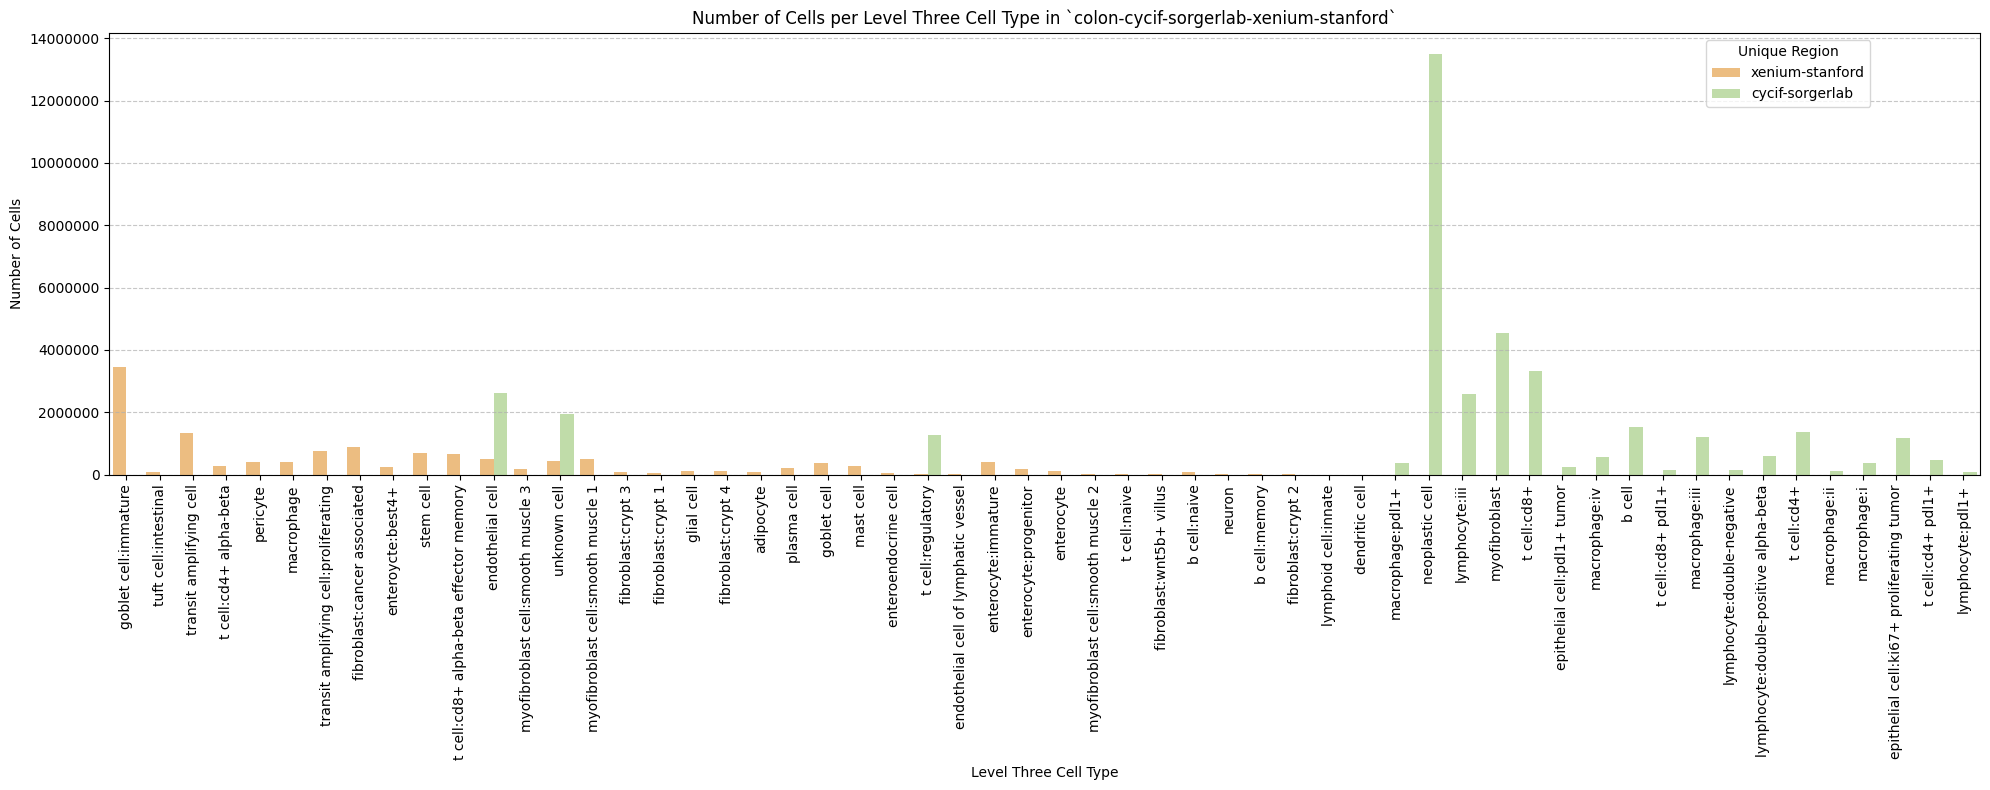

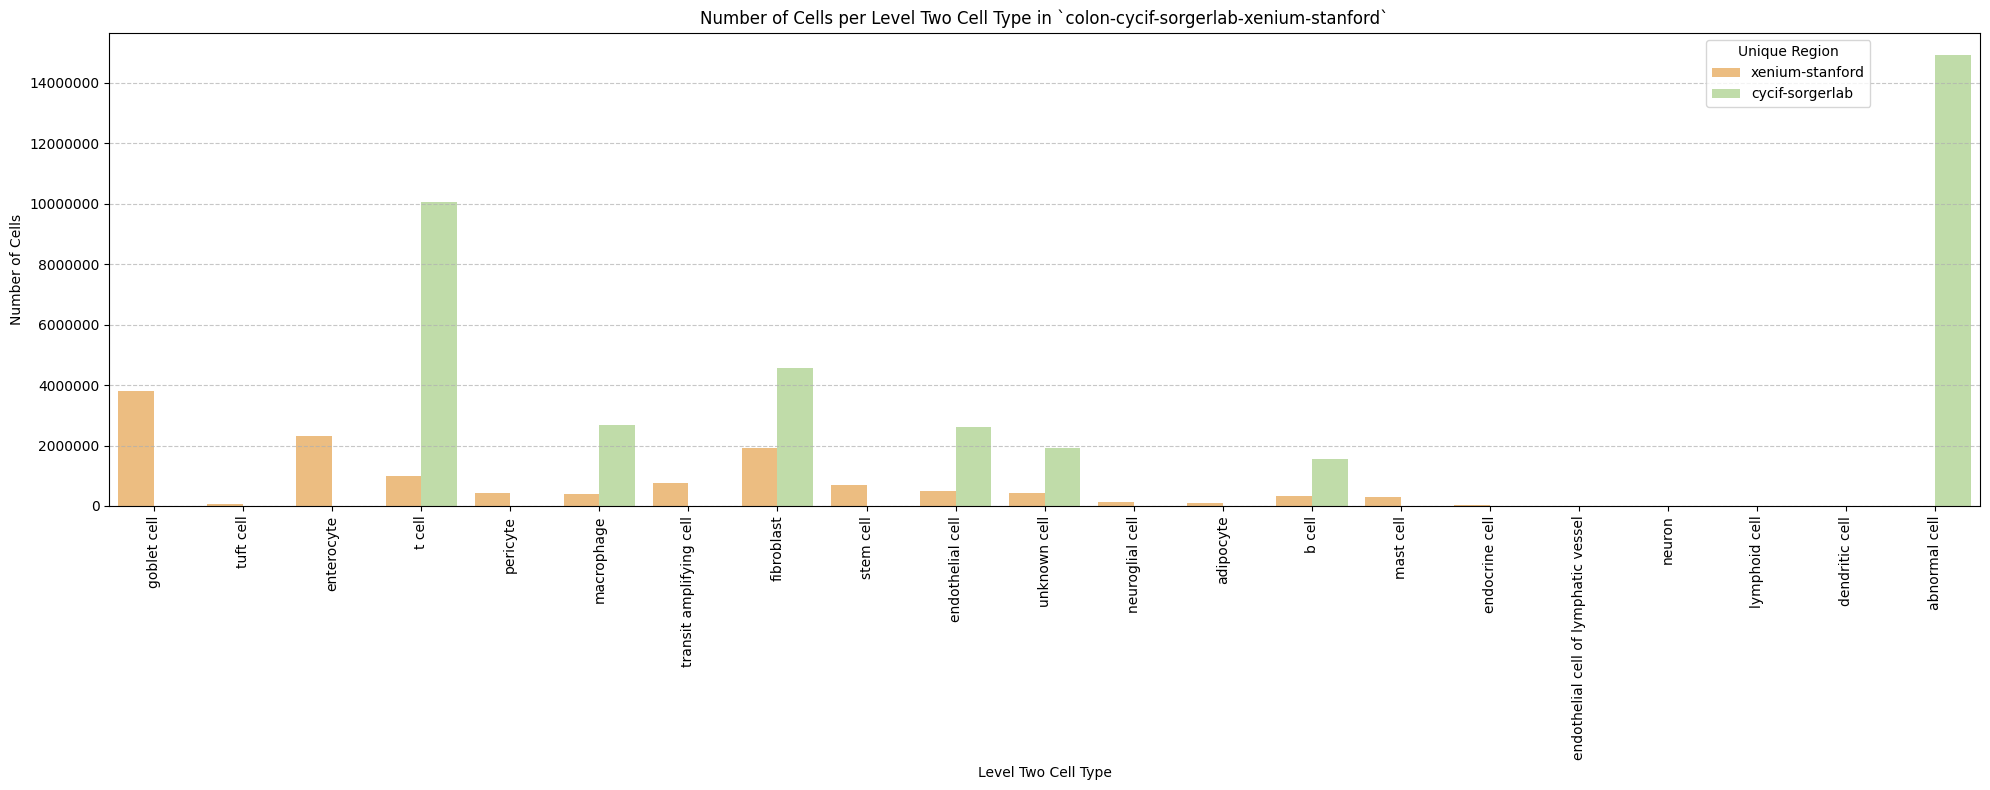

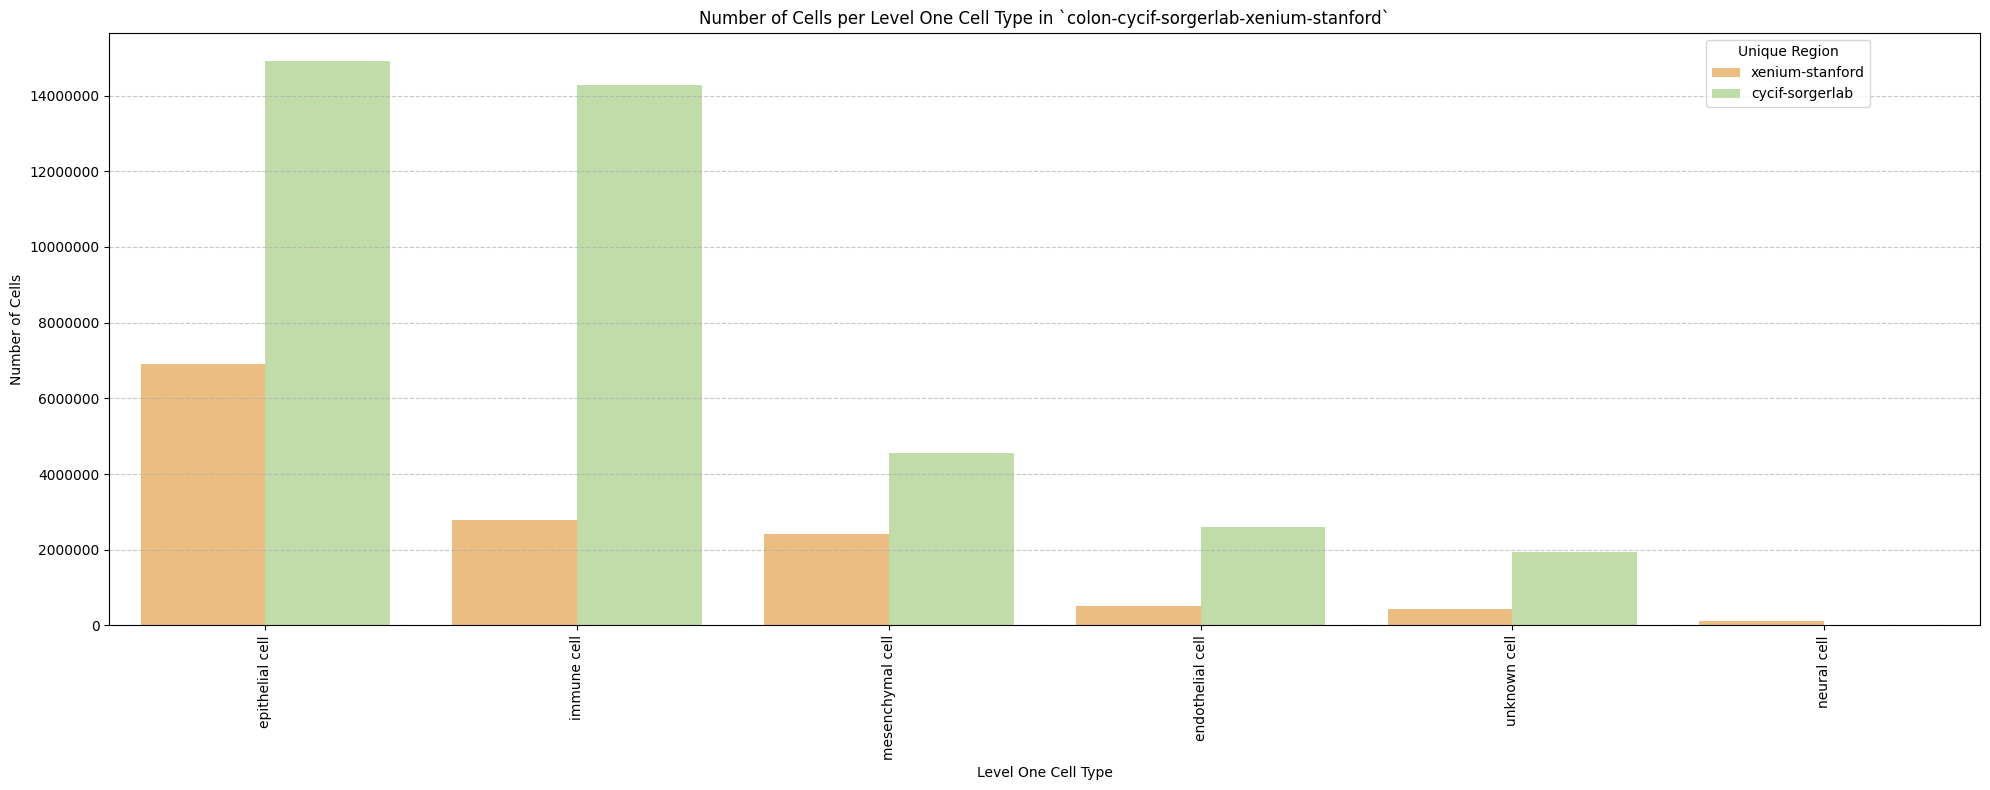

In [24]:
# Plot number of cells per cell type in the same plot. Color by cell type and unique region. Output figure saved in existing `figures_output_dir`.
def plot_cells_per_celltype(df, type_field, output_dir):
    plt.figure(figsize=(20, 8))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    sns.countplot(data=df, x=type_field, palette='Spectral', hue='Unique Region')
    plt.title(f'Number of Cells per {type_field} in `{dataset_dir}`')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{type_field}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{type_field}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.legend(title='Unique Region', bbox_to_anchor=(0.85, 1), loc='upper left')
    plt.xlabel(type_field)

    # For numbers on y-axis, do not use scientific notation.
    plt.ticklabel_format(style='plain', axis='y')
    # Set y-axis label
    plt.ylabel('Number of Cells')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Show the plot
    plt.show()
    plt.close()
for type_field in type_field_list:
    plot_cells_per_celltype(df_all_nodes, type_field, os.path.join(basepath, figures_output_dir))

## Distance Analysis

In [25]:
# Get mean, median, minimum, maximum distance per unique region per anchor cell type.
df_distance_stats = df_all_edges_with_cell_types.groupby(['Unique Region', 'Anchor Cell Type', 'Anchor Cell Type Level']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
# Print the first few rows of the distance statistics DataFrame.
df_distance_stats

,Unique Region,Anchor Cell Type,Anchor Cell Type Level,mean_distance,median_distance,min_distance,max_distance
0,cycif-sorgerlab,endothelial cell,Level One Cell Type,50.997434,41.644288,3.812328,199.999898
1,cycif-sorgerlab,endothelial cell,Level Three Cell Type,50.997434,41.644288,3.812328,199.999898
2,cycif-sorgerlab,endothelial cell,Level Two Cell Type,50.997434,41.644288,3.812328,199.999898
3,xenium-stanford,endothelial cell,Level One Cell Type,27.849965,23.669005,0.657771,199.995802
4,xenium-stanford,endothelial cell,Level Three Cell Type,28.173444,23.966392,0.657771,199.995802
5,xenium-stanford,endothelial cell,Level Two Cell Type,28.173444,23.966392,0.657771,199.995802
6,xenium-stanford,endothelial cell of lymphatic vessel,Level Three Cell Type,110.829788,111.918301,1.774604,199.999893
7,xenium-stanford,endothelial cell of lymphatic vessel,Level Two Cell Type,110.829788,111.918301,1.774604,199.999893


### Level One Cell Type Analysis

In [26]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level One Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level One Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,epithelial cell,cycif-sorgerlab,59.237837,50.521866,4.447199,199.999898
1,epithelial cell,xenium-stanford,33.029849,29.294328,0.657771,199.988725
2,immune cell,cycif-sorgerlab,43.793795,34.054817,3.812328,199.996448
3,immune cell,xenium-stanford,21.876177,17.939406,1.545798,199.762275
4,mesenchymal cell,cycif-sorgerlab,48.551081,39.884627,3.859785,199.995059
5,mesenchymal cell,xenium-stanford,20.657124,16.590299,1.097860,197.299831
6,neural cell,xenium-stanford,21.862930,17.446054,1.767815,198.410186
7,unknown cell,cycif-sorgerlab,45.301241,32.613405,4.331525,199.996828
8,unknown cell,xenium-stanford,25.550199,19.528765,1.746407,199.995802


In [27]:
# Get top five and bottom five cell types with respect to mean distance in each unique region separately.
def get_top_bottom_cell_types_by_mean(df, cell_type_level, unique_region, top_n=5):
    # Filter the DataFrame for the specified unique region and cell type level
    df_filtered = df[df['Unique Region'] == unique_region]

    # Group by the specified cell type level and calculate mean distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(mean_distance=('Distance', 'mean')).reset_index()
    
    # Sort by mean distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='mean_distance', ascending=False)
    
    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types

# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in xenium-stanford:
  Level One Cell Type  mean_distance
0     epithelial cell      33.029849
4        unknown cell      25.550199
1         immune cell      21.876177
3         neural cell      21.862930
2    mesenchymal cell      20.657124

Bottom 5 cell types in xenium-stanford:
  Level One Cell Type  mean_distance
0     epithelial cell      33.029849
4        unknown cell      25.550199
1         immune cell      21.876177
3         neural cell      21.862930
2    mesenchymal cell      20.657124

Top 5 cell types in cycif-sorgerlab:
  Level One Cell Type  mean_distance
0     epithelial cell      59.237837
2    mesenchymal cell      48.551081
3        unknown cell      45.301241
1         immune cell      43.793795

Bottom 5 cell types in cycif-sorgerlab:
  Level One Cell Type  mean_distance
0     epithelial cell      59.237837
2    mesenchymal cell      48.551081
3        unknown cell      45.301241
1         immune cell      43.793795


In [28]:
# Get top five and bottom five cell types with respect to median distance in each unique region separately.
def get_top_bottom_cell_types_by_median(df, cell_type_level, unique_region, top_n=5):
    # Filter the DataFrame for the specified unique region and cell type level
    df_filtered = df[df['Unique Region'] == unique_region]

    # Group by the specified cell type level and calculate median distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(median_distance=('Distance', 'median')).reset_index()

    # Sort by median distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='median_distance', ascending=False)

    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types

# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in xenium-stanford:
  Level One Cell Type  median_distance
0     epithelial cell        29.294328
4        unknown cell        19.528765
1         immune cell        17.939406
3         neural cell        17.446054
2    mesenchymal cell        16.590299

Bottom 5 cell types in xenium-stanford:
  Level One Cell Type  median_distance
0     epithelial cell        29.294328
4        unknown cell        19.528765
1         immune cell        17.939406
3         neural cell        17.446054
2    mesenchymal cell        16.590299

Top 5 cell types in cycif-sorgerlab:
  Level One Cell Type  median_distance
0     epithelial cell        50.521866
2    mesenchymal cell        39.884627
1         immune cell        34.054817
3        unknown cell        32.613405

Bottom 5 cell types in cycif-sorgerlab:
  Level One Cell Type  median_distance
0     epithelial cell        50.521866
2    mesenchymal cell        39.884627
1         immune cell        34.054817
3        unknown cell  

In [29]:
# Calculate regional variability
def calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level):
    """    Calculate regional variability for distances in the given DataFrame.
    """
    regional_variability = df_all_edges_with_cell_type_level.groupby('Unique Region')['Distance'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)

    # Add CV as percentage
    regional_variability['CV (%)'] = (regional_variability['std'] / regional_variability['mean'] * 100).round(1)

    print("\nRegional Variability Analysis:")
    print("Mean: Average distance in each region")
    print("Std: Standard deviation of distances")
    print("CV: Coefficient of Variation (std/mean * 100%)")
    print(regional_variability)

    # Calculate variability for each cell type
    cell_type_variability = df_all_edges_with_cell_type_level.groupby(cell_type_level)['Distance'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)

    # Add CV as percentage
    cell_type_variability['CV (%)'] = (cell_type_variability['std'] / cell_type_variability['mean'] * 100).round(1)

    print("\nCell Type Variability Analysis (sorted by CV):")
    print(cell_type_variability.sort_values('CV (%)', ascending=False))

calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                  mean    std  CV (%)
Unique Region                        
cycif-sorgerlab  51.00  35.96    70.5
xenium-stanford  27.85  19.03    68.3

Cell Type Variability Analysis (sorted by CV):
                      mean    std  CV (%)
Level One Cell Type                      
unknown cell         42.86  37.05    86.4
mesenchymal cell     41.49  33.21    80.0
immune cell          41.41  32.80    79.2
neural cell          21.86  16.10    73.7
epithelial cell      53.40  35.30    66.1


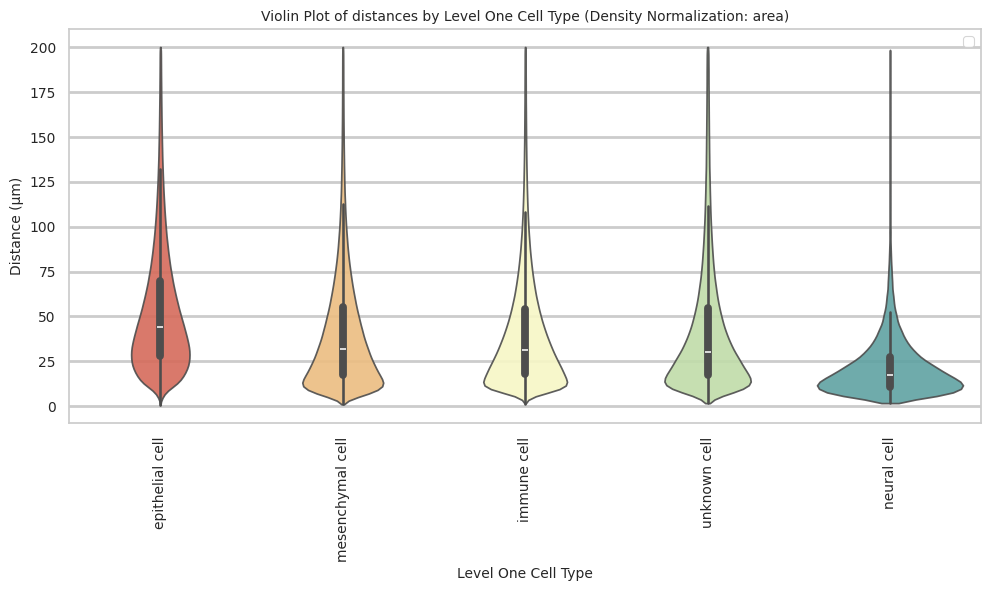

In [30]:
    # Generate Violin Plot
def plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm='area'):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 2})
    plt.figure(figsize=(10, 6))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path

    sns.violinplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y="Distance", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=False, palette='Spectral', alpha=.9)

    sns.set_theme(style="whitegrid")
    sns.set_context("paper")


    font_size = 10
    plt.legend(fontsize=font_size)

    plt.title(f'Violin Plot of distances by {cell_type_level} (Density Normalization: {density_norm})', fontsize=font_size)

    plt.xlabel(f'{cell_type_level}', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)

    # Increase font size for all text in the figure
    plt.xticks(fontsize=font_size)
    plt.xticks(rotation=90)
    plt.yticks(fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_cells_per_celltype_{cell_type_level}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_cells_per_celltype_{cell_type_level}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.show()

plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

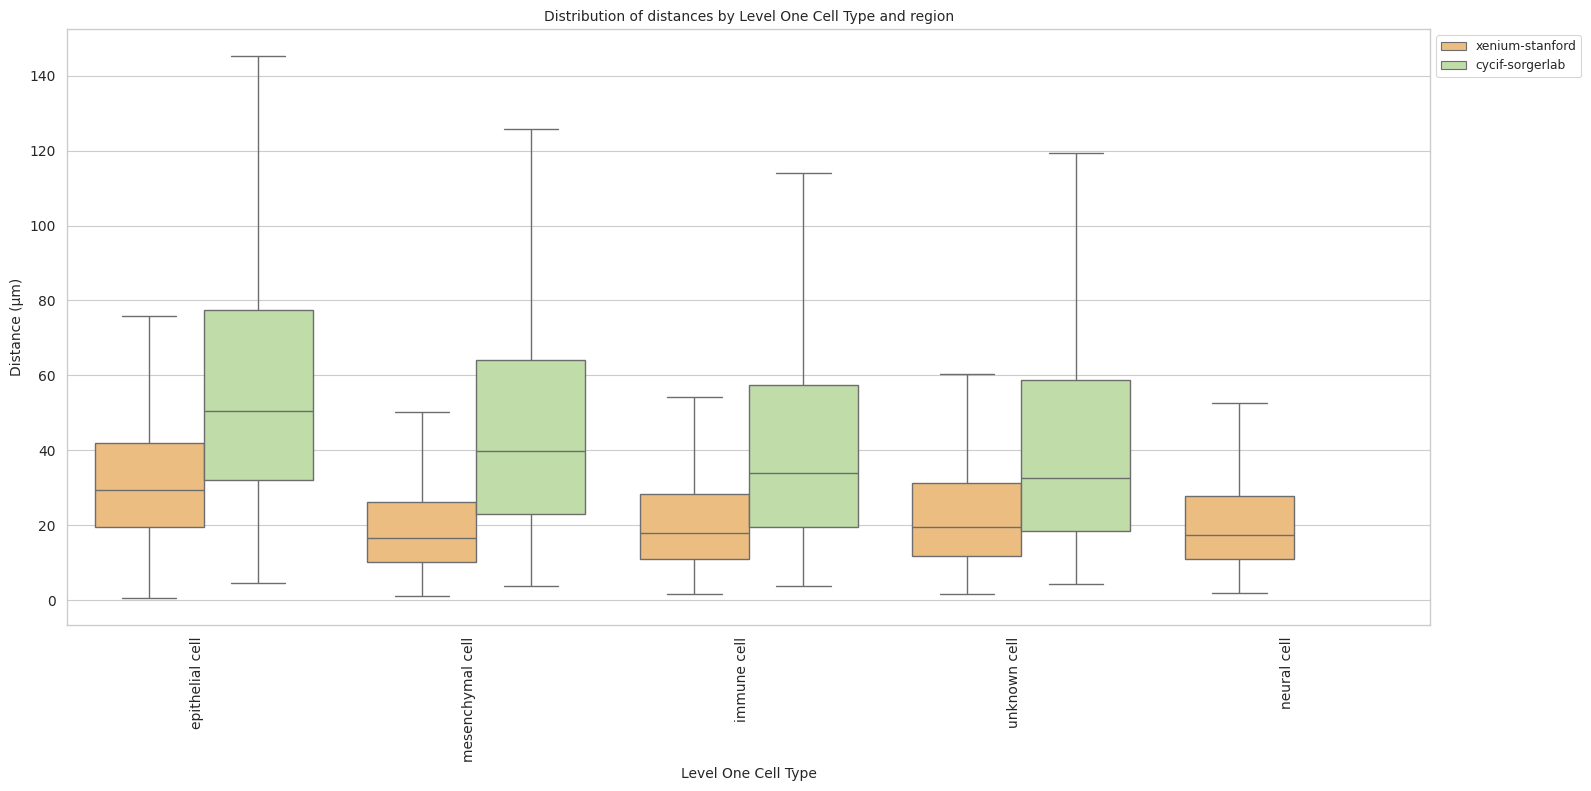

In [31]:
# Boxplots of distribution of distances by cell type and region.
def plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    plt.figure(figsize=(16, 8))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    # Create categorical type with only the regions that exist in the data
    available_regions = [r for r in regions if r in df_all_edges_with_cell_type_level['Unique Region'].unique()]
    df_all_edges_with_cell_type_level['Unique Region'] = pd.Categorical(
        df_all_edges_with_cell_type_level['Unique Region'],
        categories=available_regions,
        ordered=True
    )

    # Make box plot.
    sns.boxplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y='Distance', hue='Unique Region', showfliers=False, palette='Spectral') # viridis or Spectral palette for better color distinction
    font_size = 10
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.title(f'Distribution of distances by {cell_type_level} and region', fontsize=font_size)
    plt.xlabel(f'{cell_type_level}', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_boxplots_by_region_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_boxplots_by_region_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.show()

plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

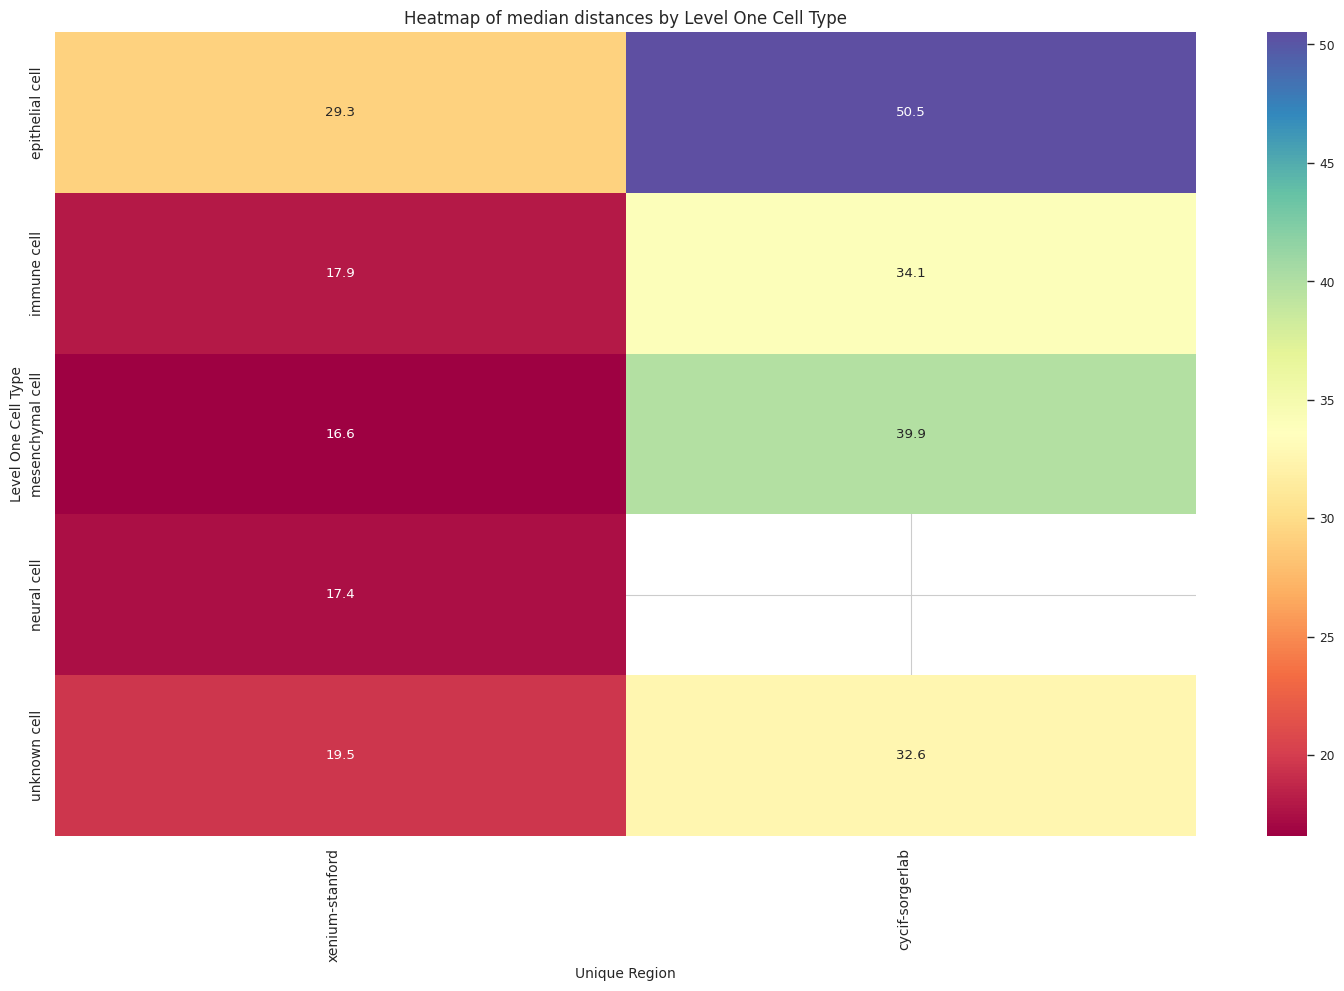

In [32]:
# Boxplots of distribution of distances by cell type and region.
def plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    pivot_data = df_all_edges_with_cell_type_level.pivot_table(
    values='Distance',
    index=cell_type_level,
    columns='Unique Region',
    aggfunc='median'
    )

    plt.figure(figsize=(15, 10))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='Spectral')
    plt.title(f'Heatmap of median distances by {cell_type_level}', fontsize=12)

    font_size = 10
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    plt.yticks(fontsize=font_size)

    plt.xlabel('Unique Region', fontsize=font_size)
    plt.ylabel(f'{cell_type_level}', fontsize=font_size)
    
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_heatmap_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_heatmap_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.show()

plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

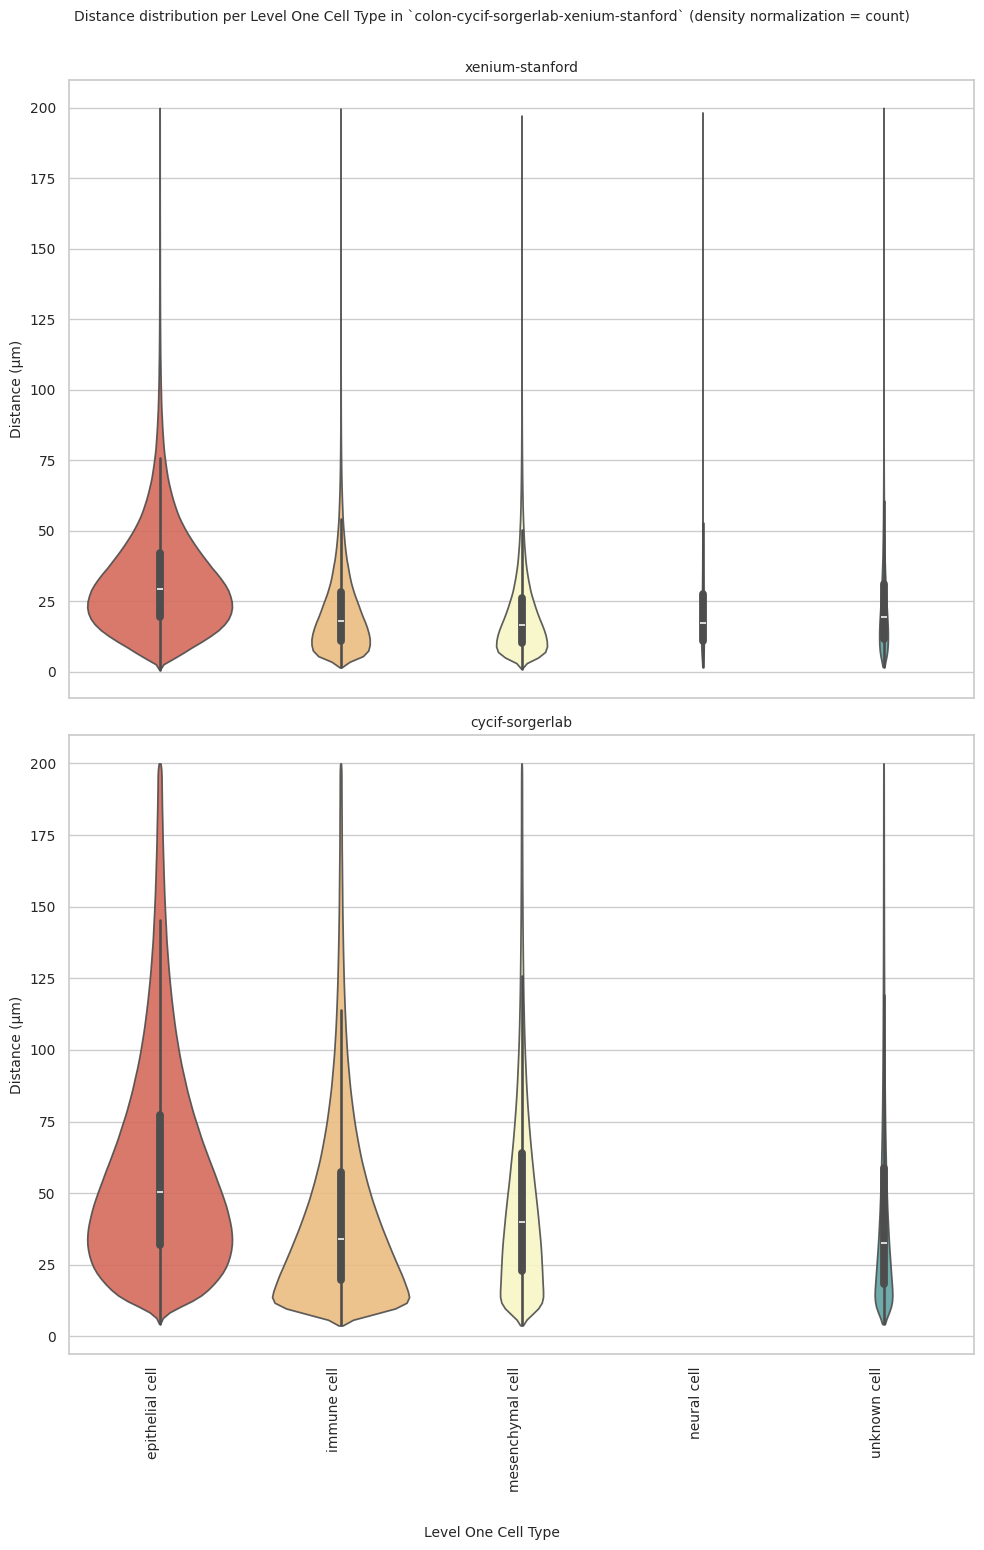

In [33]:
# Generate Violin Plot per unique region in both small intestine and large intestine. Create for all 8 regions as 8 subplots.
def plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm="area"):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 1})
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path
    font_size = 10
    fig, axs = plt.subplots(2, 1, figsize=(10, 15)) # Adjusted figsize for horizontal layout
    fig.suptitle(f'Distance distribution per {cell_type_level} in `{dataset_dir}` (density normalization = {density_norm})', fontsize=font_size, y=1)

    # Keep the sequence of Cell Types consistent across plots.
    cell_types = sorted(df_all_edges_with_cell_type_level[cell_type_level].unique())

    # Create a color palette based on the number of unique classes
    color_palette = sns.color_palette("Spectral", n_colors=len(cell_types))

    # Create a dictionary mapping class to color
    class_color_dict = dict(zip(cell_types, color_palette))

    for i, region in enumerate(regions):
        data_reg = df_all_edges_with_cell_type_level[df_all_edges_with_cell_type_level['Unique Region'] == region]
        sns.violinplot(data=data_reg, x=cell_type_level, y="Distance", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=False, palette=class_color_dict, alpha=.9, ax=axs[i], hue=cell_type_level, legend=False, order=cell_types, fill=True)
        axs[i].set_title(region, fontsize=font_size)
        axs[i].set_xlabel('', fontsize=font_size)
        axs[i].set_ylabel('Distance (\u03bcm)', fontsize=font_size)
        # axs[i].tick_params(axis='x', labelrotation=90, labelsize=font_size)
        # only show xtick labels for the last subplot
        if i < len(regions) - 1:
            axs[i].set_xticklabels([])
        else:
            axs[i].set_xticklabels(cell_types, fontsize=font_size, rotation=90, ha='right')
        # axs[i].set_ylim(0, data_reg['Distance'].max() * 1.1)  # Set y-limits to be consistent across all plots
        axs[i].tick_params(axis='both', labelsize=font_size)

    # Use fig.text for precise label positioning
    fig.figure.text(0.5, -0.02, f'{cell_type_level}', ha='center', va='bottom', fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_plots_all_regions_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_plots_all_regions_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    
    plt.show()

plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # density_norm="count" or "area" can be used based on preference.

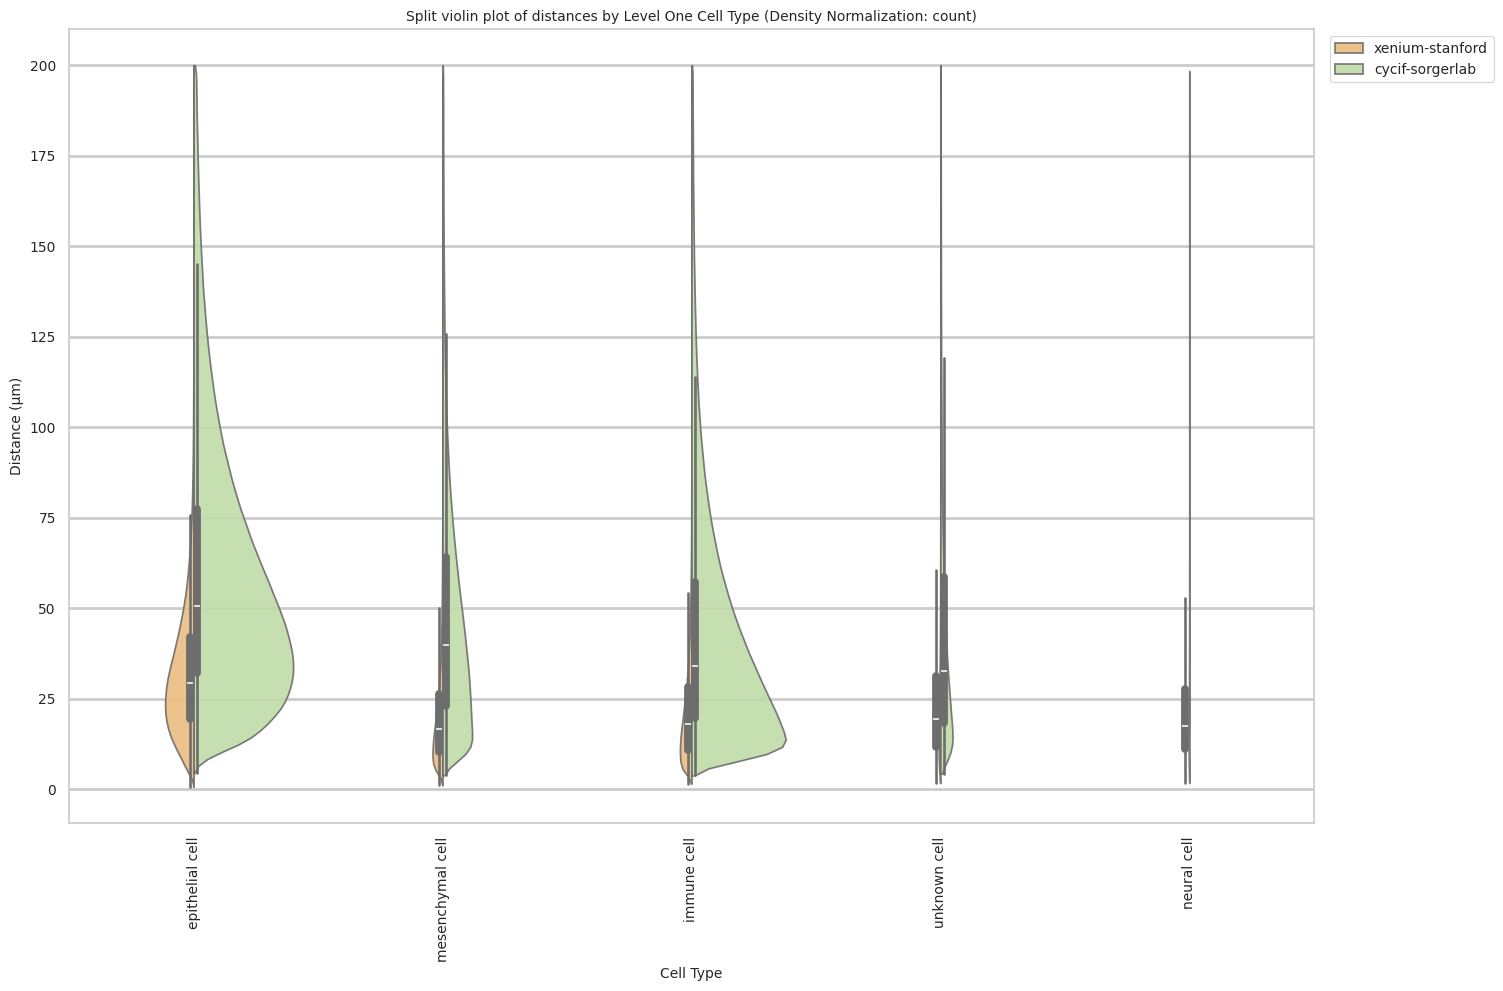

In [34]:
# Generate Split Violin Plot
def plot_violin_cells_per_celltype_split_by_condition(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm="area"):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 2})
    plt.figure(figsize=(15, 10))
    plt.rcParams["svg.fonttype"] = 'none'  # to store text as text, not as path

    sns.violinplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y="Distance", hue="Unique Region", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=True, palette='Spectral', alpha=.9, hue_order=regions)

    sns.set_theme(style="whitegrid")
    sns.set_context("paper")


    font_size = 10
    plt.legend(fontsize=font_size, loc='upper right', bbox_to_anchor=(1.15, 1))

    plt.title(f'Split violin plot of distances by {cell_type_level} (Density Normalization: {density_norm})', fontsize=font_size)

    plt.xlabel('Cell Type', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)

    # Increase font size for all text in the figure
    plt.xticks(fontsize=font_size)
    plt.xticks(rotation=90)
    plt.yticks(fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_plot_violin_cells_per_celltype_split_by_condition_{cell_type_level}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_plot_violin_cells_per_celltype_split_by_condition_{cell_type_level}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.show()

plot_violin_cells_per_celltype_split_by_condition(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # density_norm="count" or "area" can be used based on preference.

### Level Two Cell Type Analysis

In [35]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level Two Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level Two Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,abnormal cell,cycif-sorgerlab,59.237837,50.521866,4.447199,199.999898
1,adipocyte,xenium-stanford,19.307335,15.506267,1.886588,179.829816
2,b cell,cycif-sorgerlab,44.742812,36.696395,3.812328,199.963430
3,b cell,xenium-stanford,19.868268,16.177394,1.545798,193.686073
4,dendritic cell,xenium-stanford,19.604743,16.317067,3.127862,82.356448
5,endocrine cell,xenium-stanford,28.989088,25.386019,1.870109,187.875767
6,endothelial cell of lymphatic vessel,xenium-stanford,20.220957,16.182602,1.837223,191.459774
7,enterocyte,xenium-stanford,35.016424,30.665961,1.416608,199.988725
8,fibroblast,cycif-sorgerlab,48.551081,39.884627,3.859785,199.995059
9,fibroblast,xenium-stanford,20.925389,16.923950,1.097860,197.299831


In [36]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in xenium-stanford:
        Level Two Cell Type  mean_distance
5                enterocyte      35.016424
7               goblet cell      32.837030
17                tuft cell      31.969551
14                stem cell      31.434218
16  transit amplifying cell      29.750915

Bottom 5 cell types in xenium-stanford:
   Level Two Cell Type  mean_distance
2       dendritic cell      19.604743
0            adipocyte      19.307335
10           mast cell      18.454766
8        lymphoid cell      18.157623
9           macrophage      17.955820

Top 5 cell types in cycif-sorgerlab:
  Level Two Cell Type  mean_distance
0       abnormal cell      59.237837
2          fibroblast      48.551081
5        unknown cell      45.301241
1              b cell      44.742812
3          macrophage      43.943644

Bottom 5 cell types in cycif-sorgerlab:
  Level Two Cell Type  mean_distance
2          fibroblast      48.551081
5        unknown cell      45.301241
1              b cell  

In [37]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])



Top 5 cell types in xenium-stanford:
        Level Two Cell Type  median_distance
5                enterocyte        30.665961
17                tuft cell        29.702991
7               goblet cell        29.215176
14                stem cell        28.909495
16  transit amplifying cell        25.985201

Bottom 5 cell types in xenium-stanford:
                     Level Two Cell Type  median_distance
4   endothelial cell of lymphatic vessel        16.182602
1                                 b cell        16.177394
0                              adipocyte        15.506267
10                             mast cell        15.402588
9                             macrophage        14.656862

Top 5 cell types in cycif-sorgerlab:
  Level Two Cell Type  median_distance
0       abnormal cell        50.521866
2          fibroblast        39.884627
1              b cell        36.696395
4              t cell        33.735886
3          macrophage        33.602981

Bottom 5 cell types in cycif-s

In [38]:
calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                  mean    std  CV (%)
Unique Region                        
cycif-sorgerlab  51.00  35.96    70.5
xenium-stanford  28.17  19.20    68.2

Cell Type Variability Analysis (sorted by CV):
                                       mean    std  CV (%)
Level Two Cell Type                                       
unknown cell                          42.93  37.03    86.3
macrophage                            41.74  33.88    81.2
t cell                                42.22  33.30    78.9
fibroblast                            42.72  33.53    78.5
pericyte                              21.26  16.63    78.2
endothelial cell of lymphatic vessel  20.22  15.35    75.9
neuroglial cell                       22.06  16.31    73.9
b cell                                41.76  30.62    73.3
adipocyte                             19.31  14.10    73

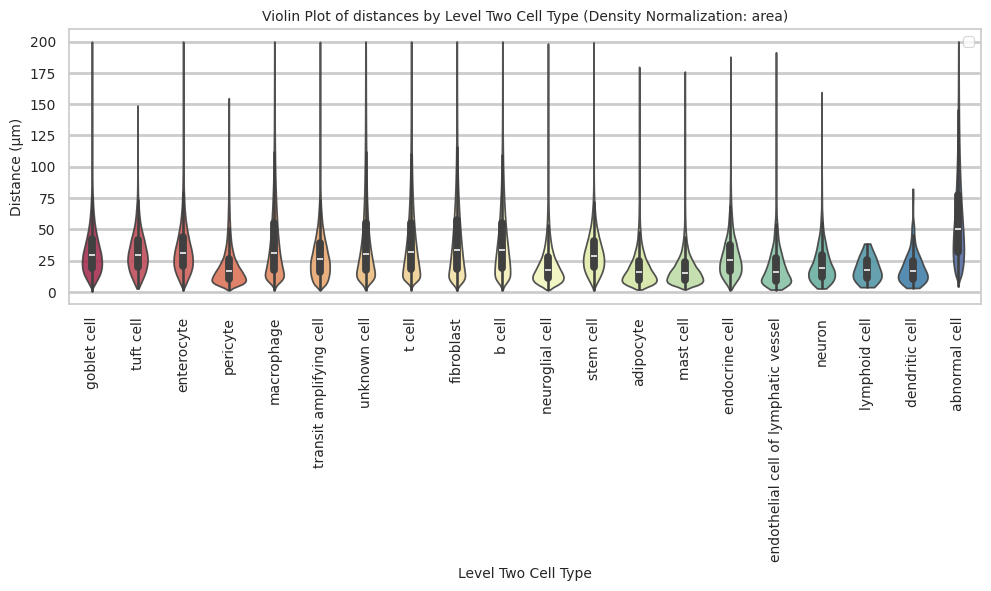

In [39]:
plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

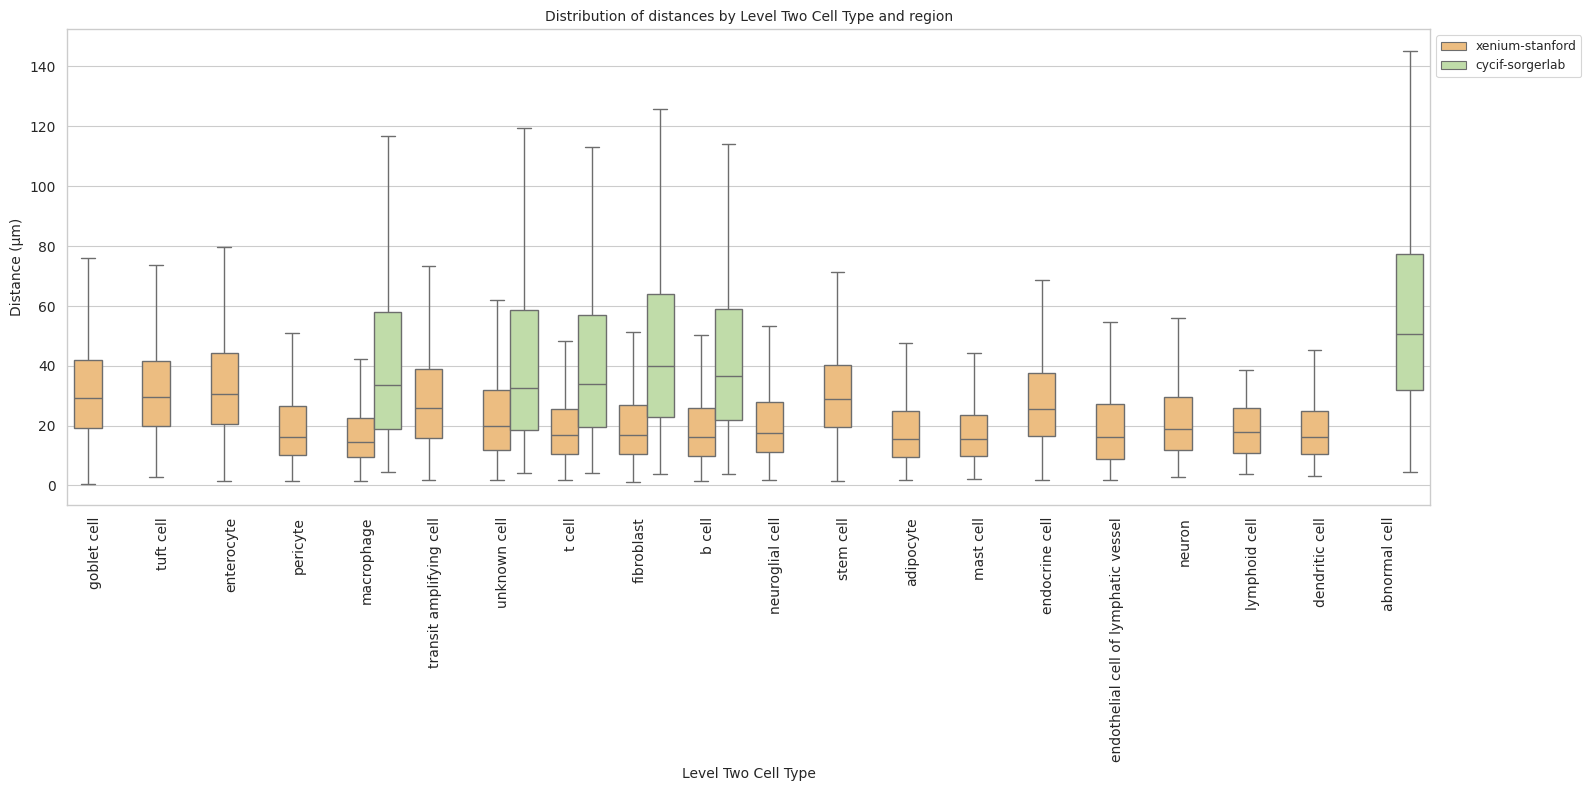

In [40]:
plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

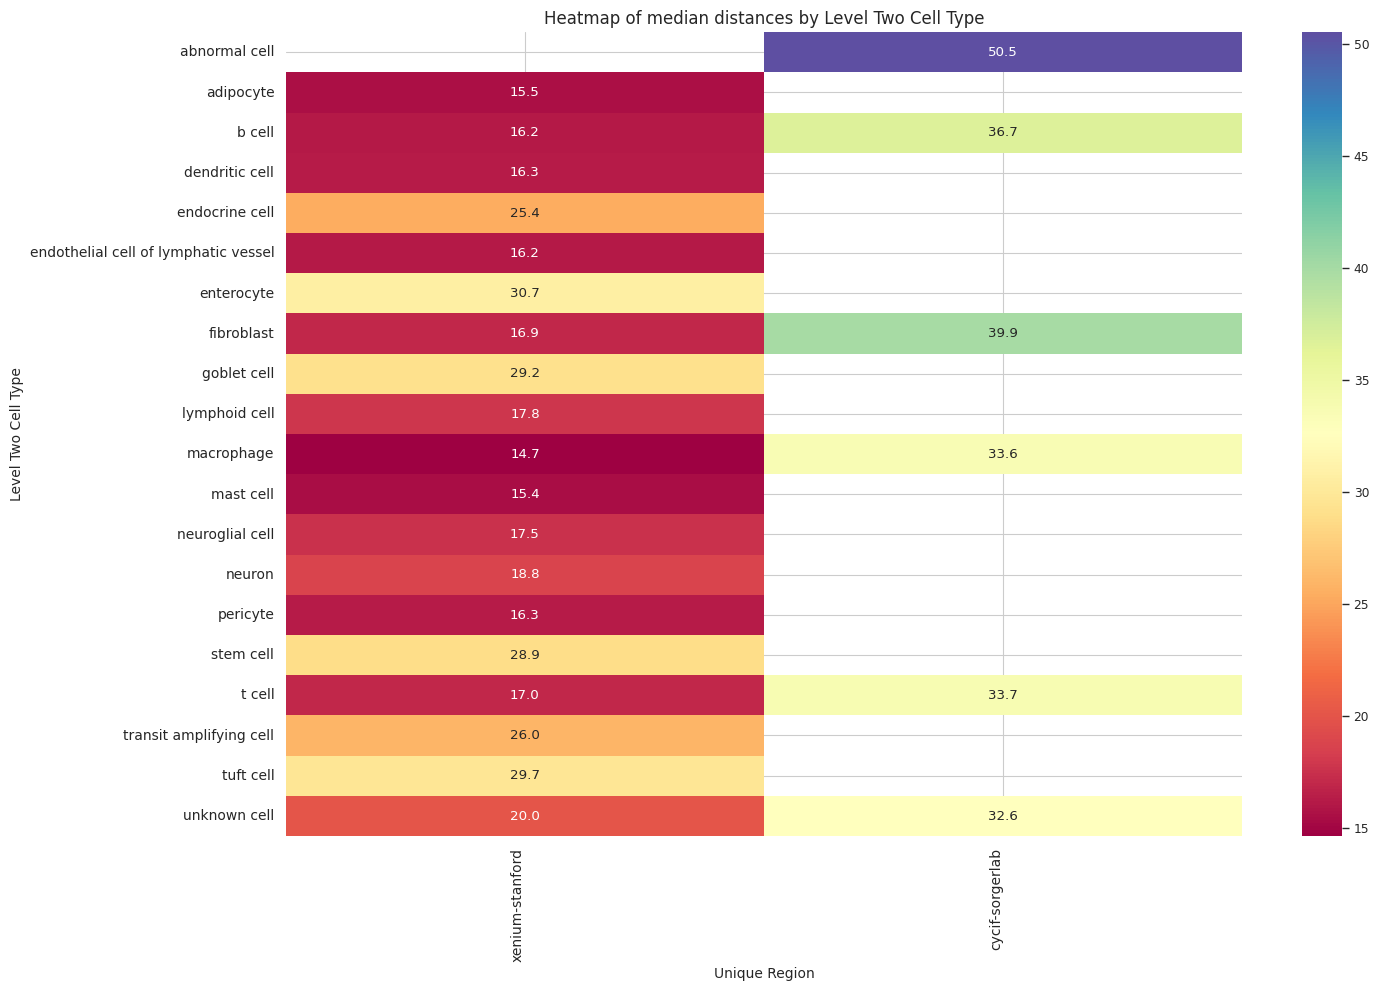

In [41]:
plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

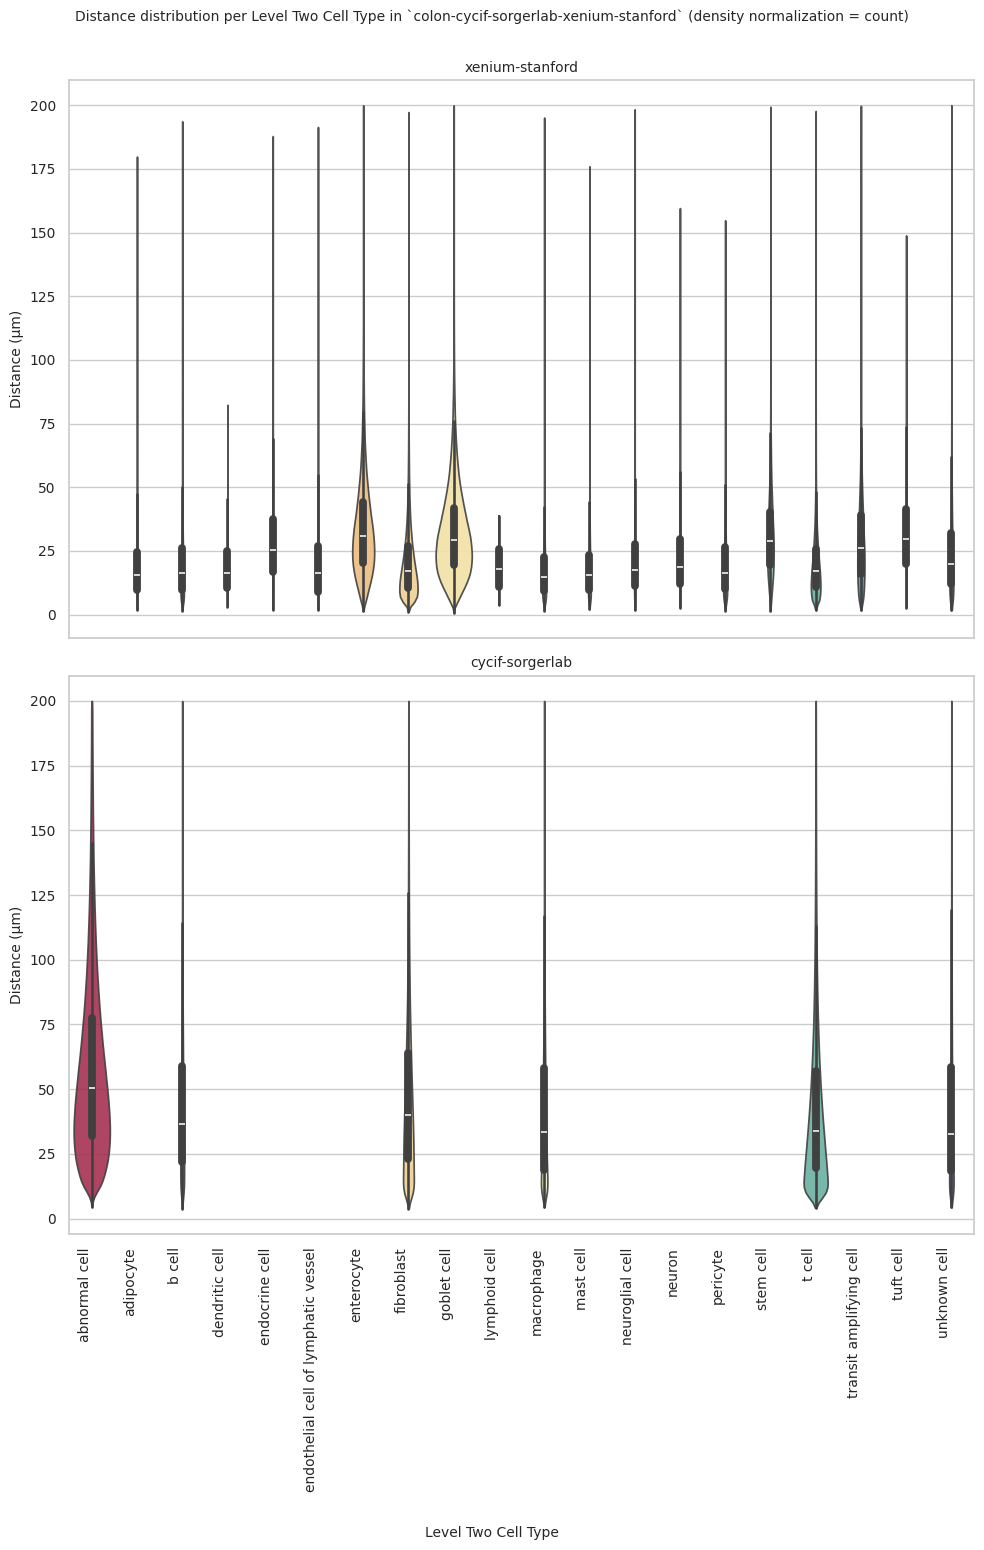

In [42]:
plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count" or "area" based on preference.

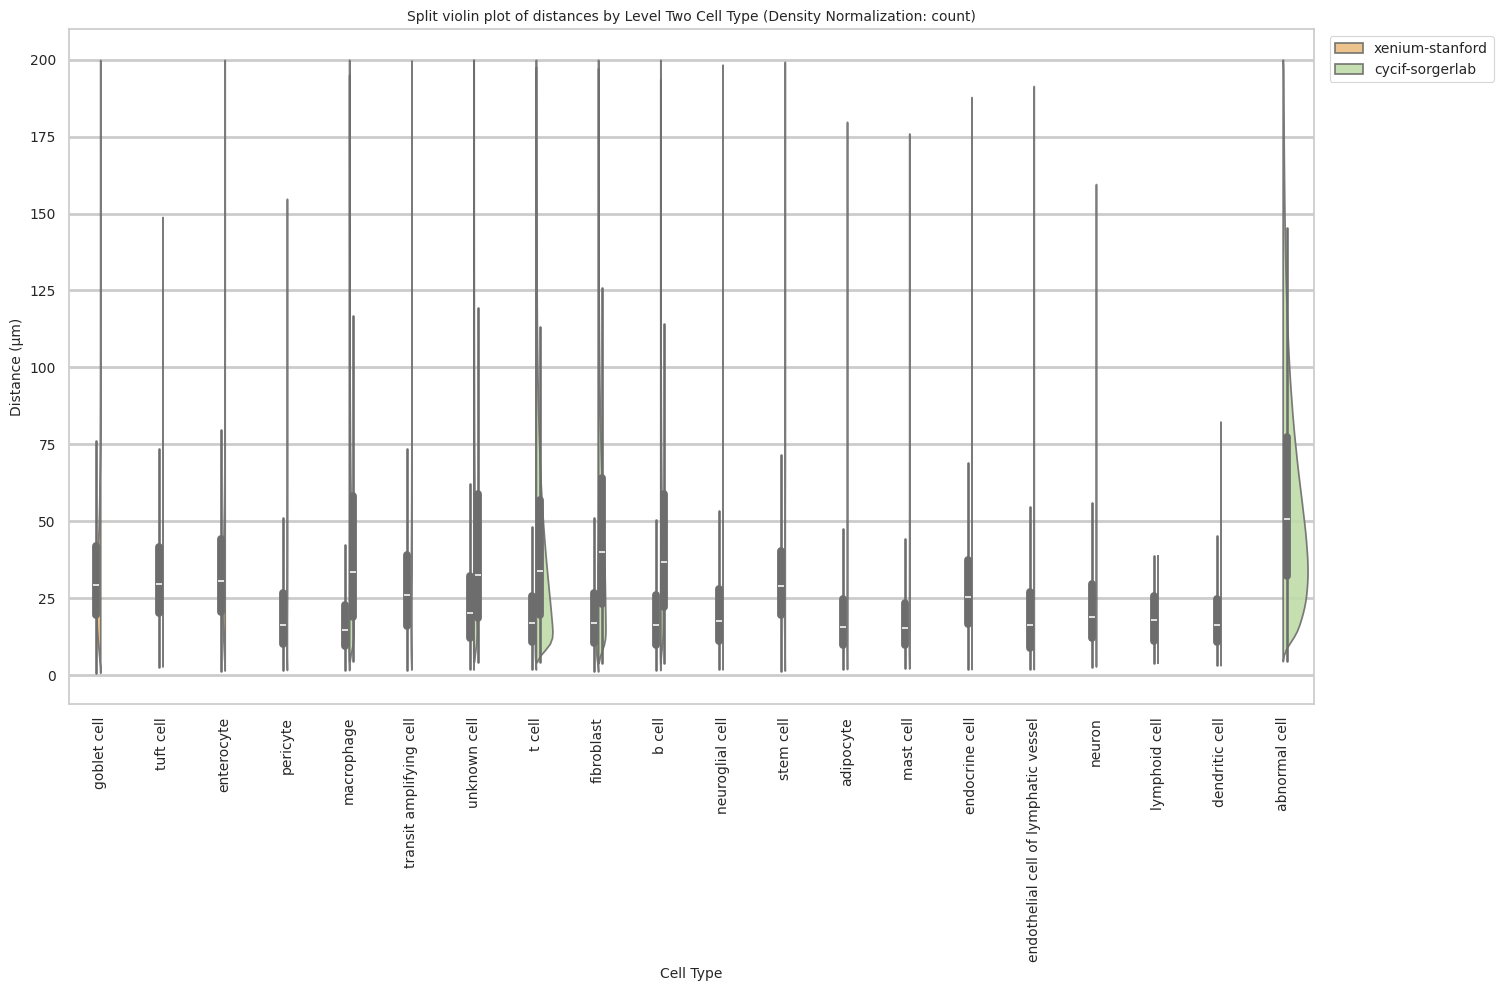

In [43]:
plot_violin_cells_per_celltype_split_by_condition(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # density_norm="count" or "area" can be used based on preference.

### Level Three Cell Type Analysis

In [44]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level Three Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level Three Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,adipocyte,xenium-stanford,19.307335,15.506267,1.886588,179.829816
1,b cell,cycif-sorgerlab,44.742812,36.696395,3.812328,199.963430
2,b cell:memory,xenium-stanford,23.934378,20.983564,2.652329,166.226299
3,b cell:naive,xenium-stanford,24.730393,21.919130,2.399703,158.517322
4,dendritic cell,xenium-stanford,19.604743,16.317067,3.127862,82.356448
5,endothelial cell of lymphatic vessel,xenium-stanford,20.220957,16.182602,1.837223,191.459774
6,enterocyte,xenium-stanford,50.881839,44.856792,2.963287,199.368285
7,enterocyte:immature,xenium-stanford,40.557414,34.829782,1.689435,199.988725
8,enterocyte:progenitor,xenium-stanford,33.809577,30.032085,1.776411,198.196246
9,enteroendocrine cell,xenium-stanford,28.989088,25.386019,1.870109,187.875767


In [45]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in xenium-stanford:
    Level Three Cell Type  mean_distance
5              enterocyte      50.881839
6     enterocyte:immature      40.557414
9       enteroycte:best4+      37.294043
7   enterocyte:progenitor      33.809577
17            goblet cell      33.697180

Bottom 5 cell types in xenium-stanford:
           Level Three Cell Type  mean_distance
10  fibroblast:cancer associated      18.840371
21                     mast cell      18.454766
19          lymphoid cell:innate      18.157623
20                    macrophage      17.955820
27                   plasma cell      17.203358

Top 5 cell types in cycif-sorgerlab:
                        Level Three Cell Type  mean_distance
13                            neoplastic cell      59.784714
1   epithelial cell:ki67+ proliferating tumor      54.524579
2                 epithelial cell:pdl1+ tumor      52.223131
12                              myofibroblast      48.551081
16                                t cell:cd8

In [46]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in xenium-stanford:
    Level Three Cell Type  median_distance
5              enterocyte        44.856792
6     enterocyte:immature        34.829782
9       enteroycte:best4+        33.070860
7   enterocyte:progenitor        30.032085
35   tuft cell:intestinal        29.702991

Bottom 5 cell types in xenium-stanford:
           Level Three Cell Type  median_distance
0                      adipocyte        15.506267
10  fibroblast:cancer associated        15.427564
21                     mast cell        15.402588
20                    macrophage        14.656862
27                   plasma cell        13.864204

Top 5 cell types in cycif-sorgerlab:
                        Level Three Cell Type  median_distance
13                            neoplastic cell        50.975228
1   epithelial cell:ki67+ proliferating tumor        47.126741
2                 epithelial cell:pdl1+ tumor        44.654349
12                              myofibroblast        39.884627
16        

In [47]:
calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                  mean    std  CV (%)
Unique Region                        
cycif-sorgerlab  51.00  35.96    70.5
xenium-stanford  28.17  19.20    68.2

Cell Type Variability Analysis (sorted by CV):
                                            mean    std  CV (%)
Level Three Cell Type                                          
unknown cell                               42.93  37.03    86.3
macrophage:i                               38.48  31.75    82.5
lymphocyte:double-negative                 41.21  33.52    81.3
lymphocyte:iii                             47.36  38.13    80.5
macrophage:iii                             45.98  36.40    79.2
macrophage:iv                              45.89  35.94    78.3
pericyte                                   21.26  16.63    78.2
t cell:cd4+                                38.98  30.34    77.8
fibrob

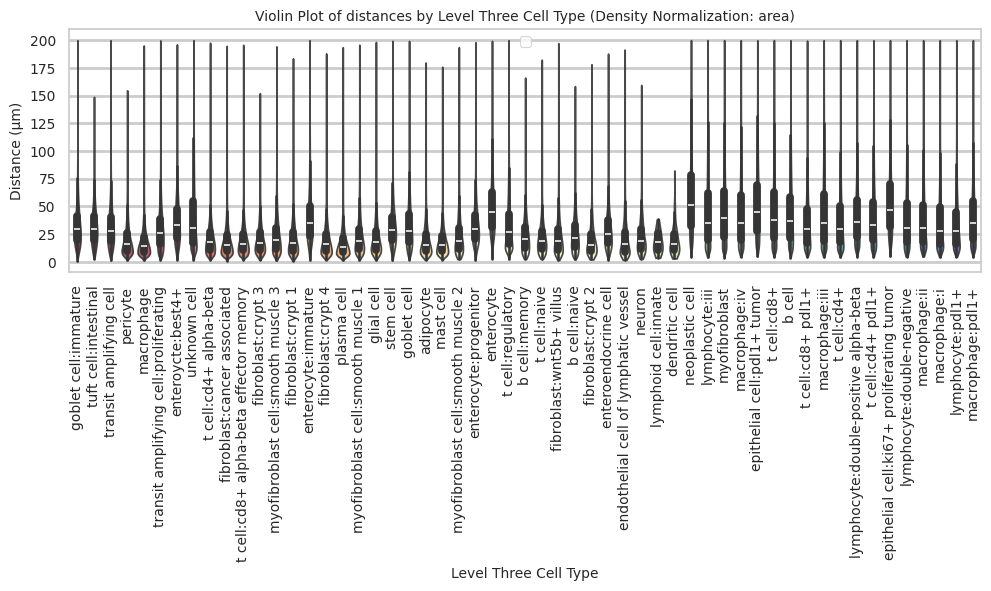

In [48]:
plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

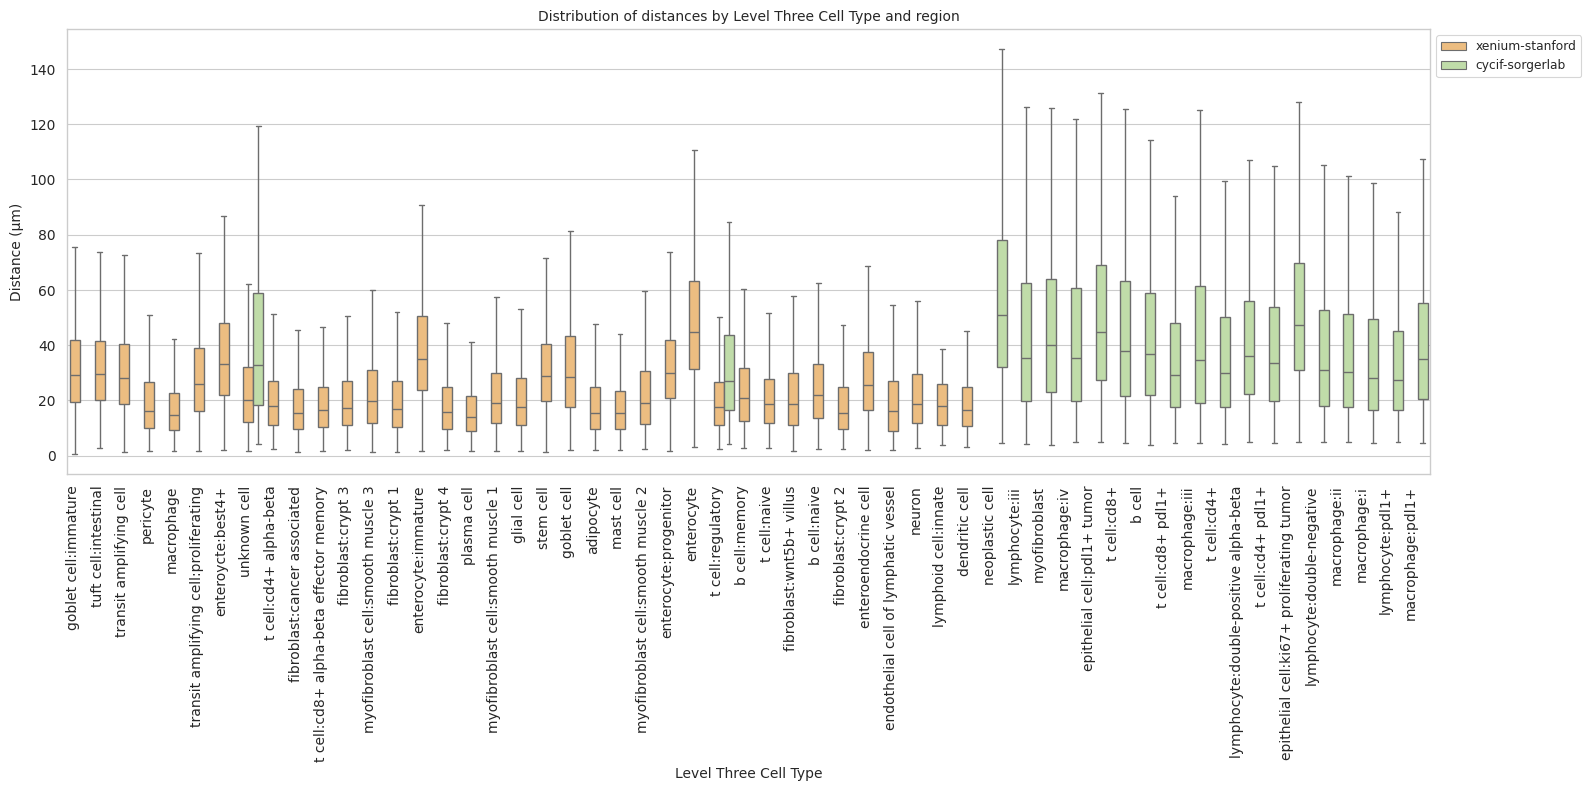

In [49]:
plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

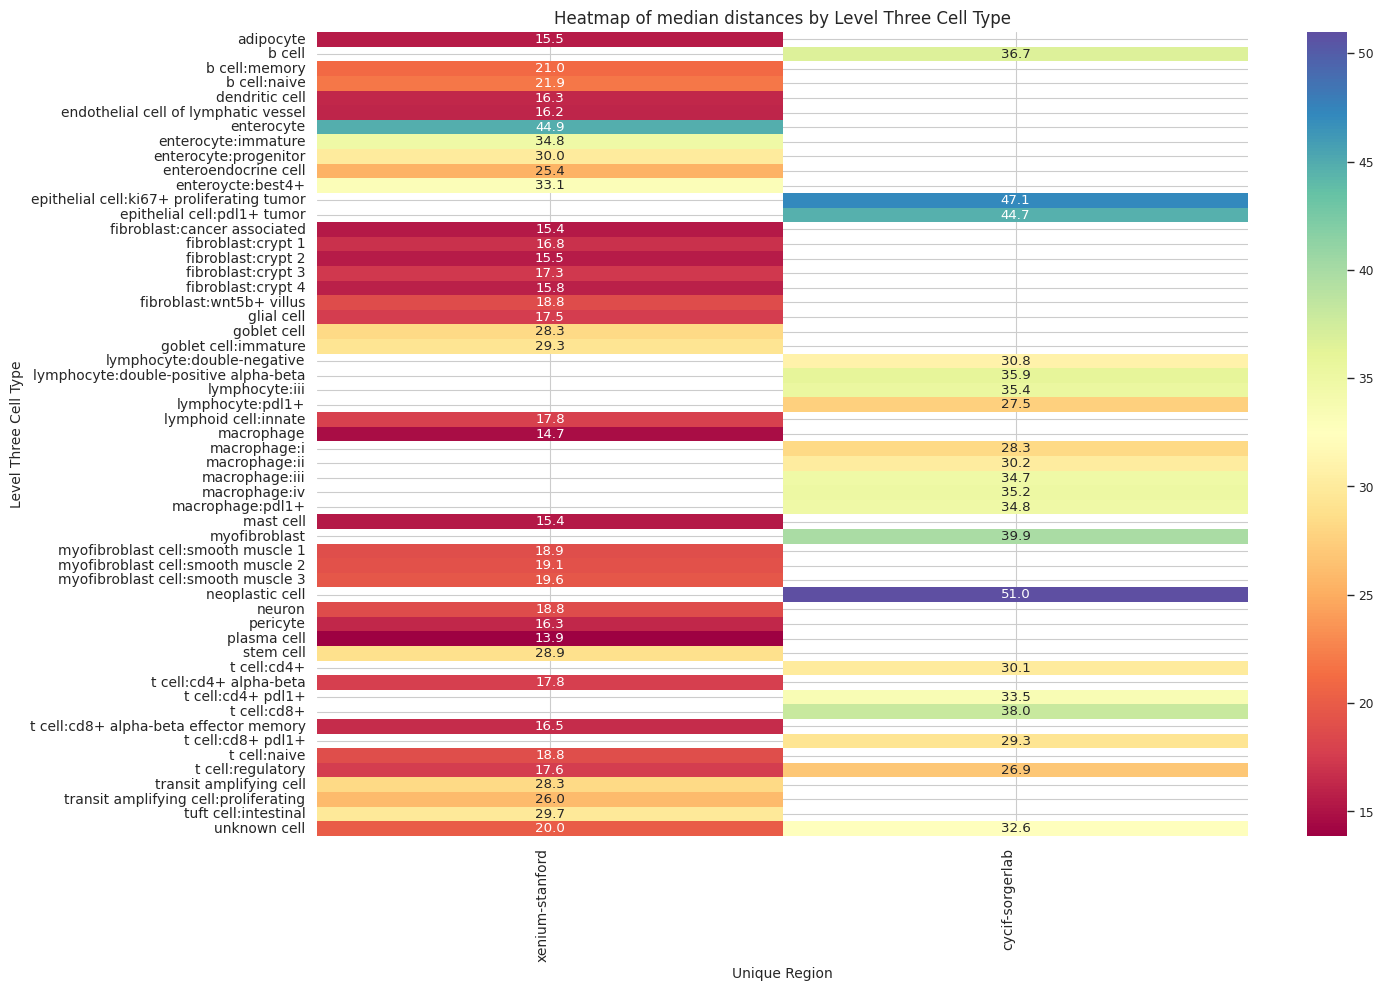

In [50]:
plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

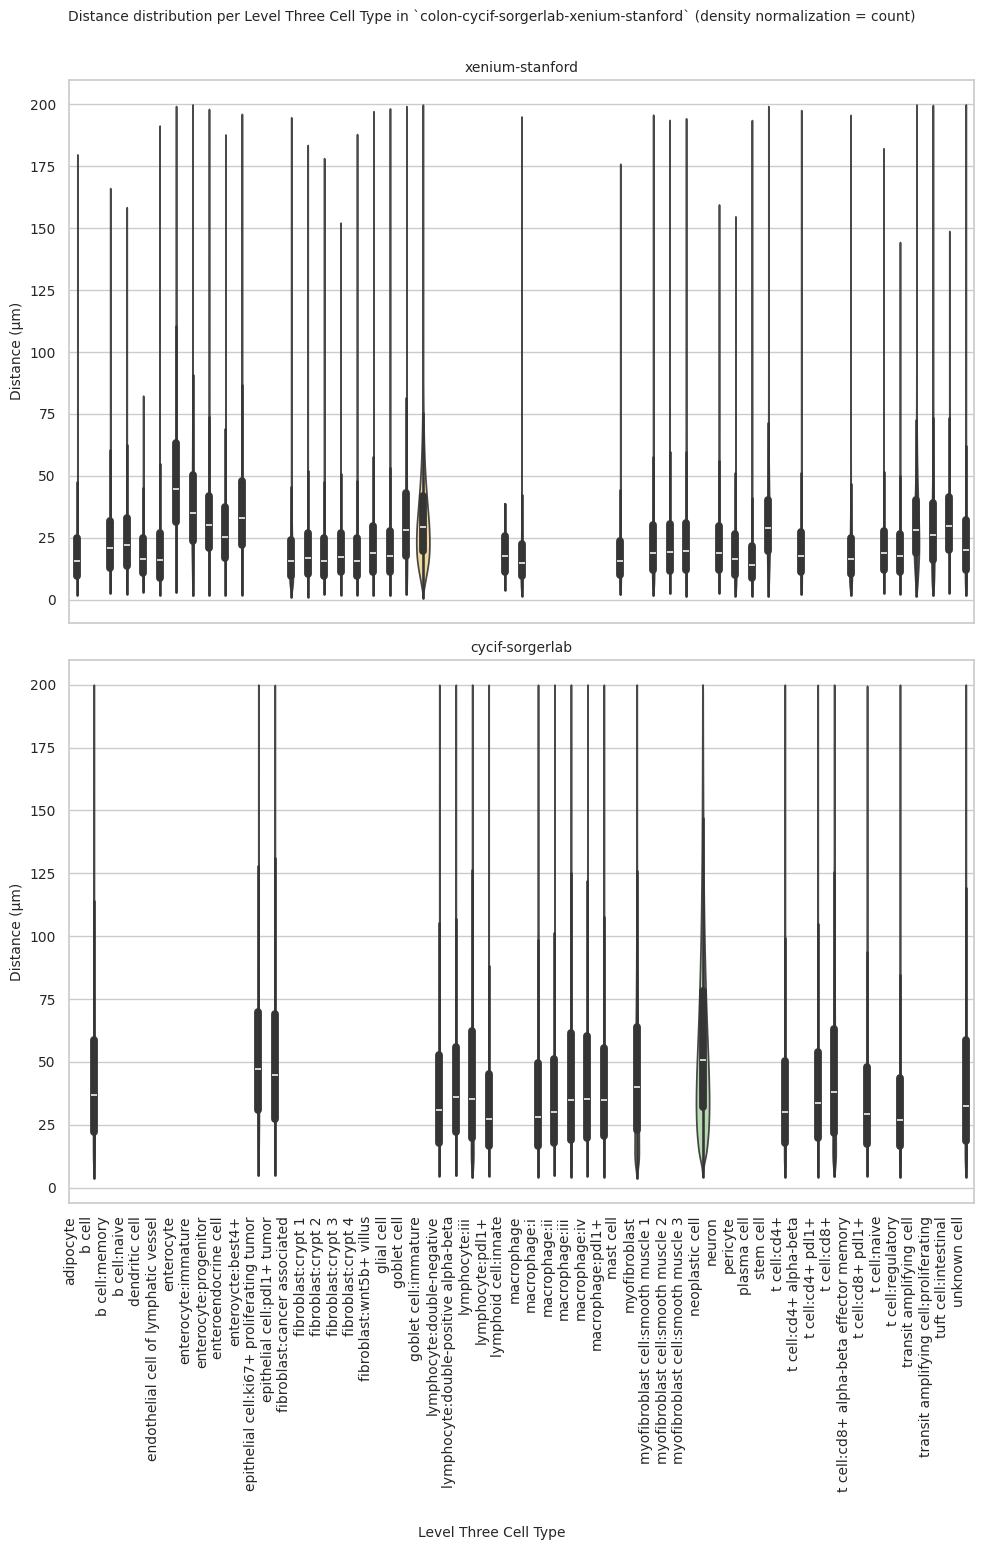

In [51]:
plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count" or "area" based on preference.

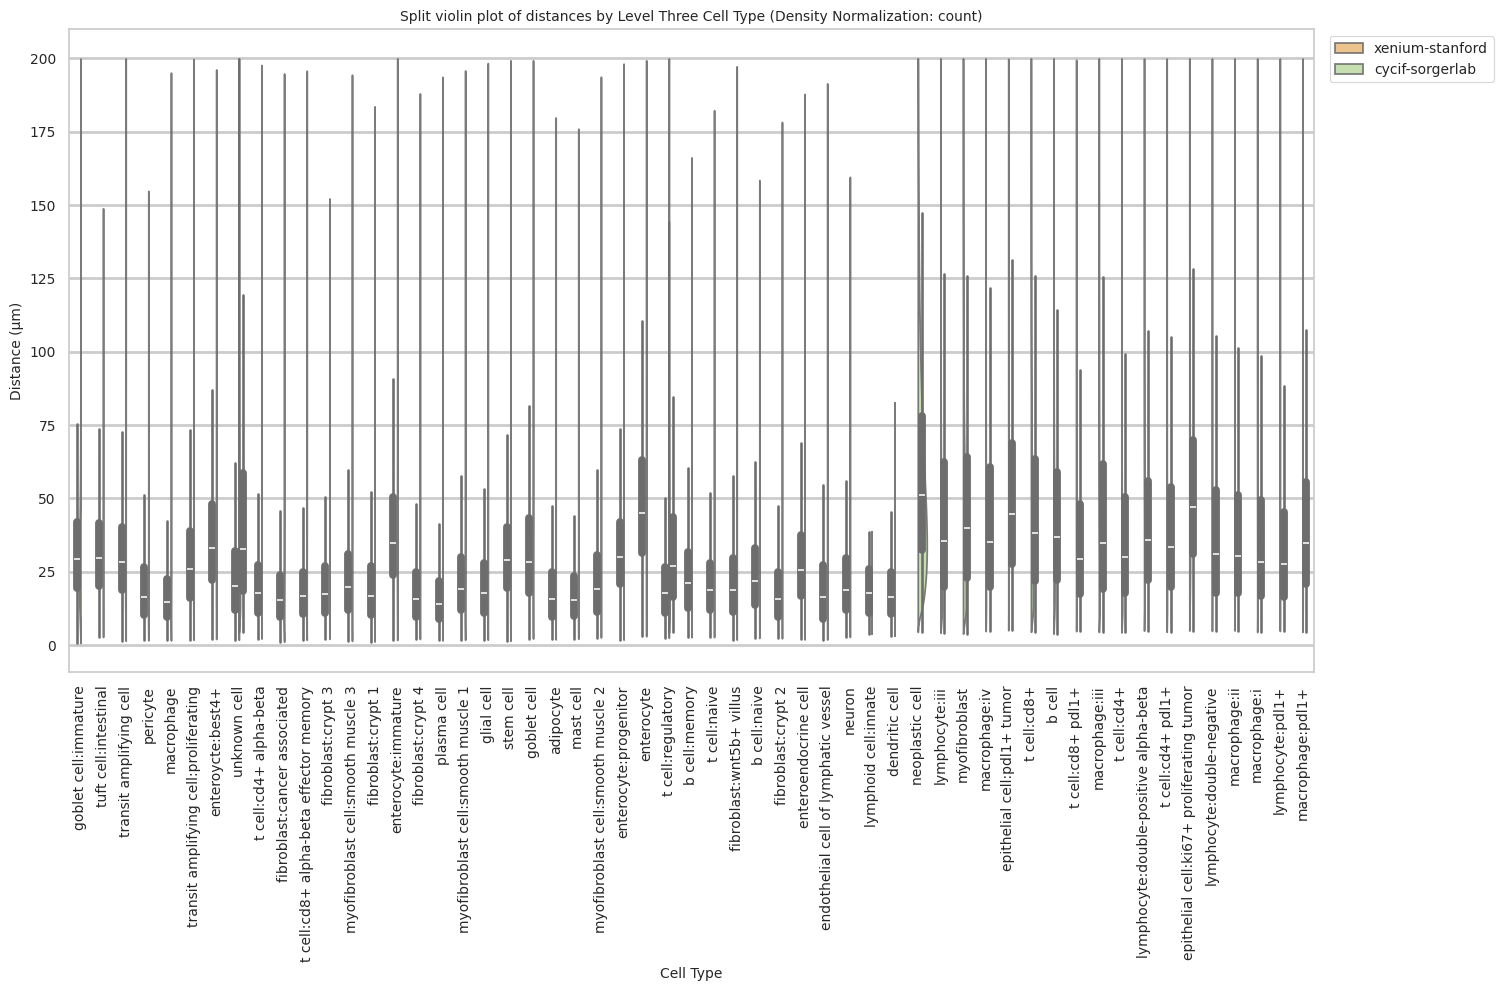

In [52]:
plot_violin_cells_per_celltype_split_by_condition(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # density_norm="count" or "area" can be used based on preference.